In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import torch.nn as nn
import torch.optim as optim
import math
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import datetime

import random
from skopt import BayesSearchCV

In [2]:
data = pd.read_excel('./Data/New_data11.xlsx')
data_pop = pd.read_excel('./Data/population_2013_2072.xlsx')

In [3]:
for i in range(2013,2025):
    data_pop.loc[data_pop['year']==i,0] = data.loc[data['Year']==i,'Population_0'].iloc[0]
    data_pop.loc[data_pop['year']==i,40] = data.loc[data['Year']==i,'Population_40'].iloc[0]
    data_pop.loc[data_pop['year']==i,60] = data.loc[data['Year']==i,'Population_60'].iloc[0]

In [4]:
Climber = pd.read_excel('./Data/Climber.xlsx')

In [5]:
chuseok_dates = pd.read_excel('./Data/추석날짜.xlsx')

In [6]:
chuseok_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    57 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 588.0 bytes


In [7]:
chuseok_week = []
# 각 해의 추석 날짜가 몇 번째 주에 속하는지 계산
for date_str in chuseok_dates['date'].values:
    chuseok_date = date_str.astype('datetime64[s]').astype(datetime.datetime)
    chuseok_week.append(chuseok_date.isocalendar()[1])  # ISO 캘린더에서 주차 계산
print(chuseok_week)

[37, 39, 37, 40, 39, 37, 40, 38, 36, 39, 38, 41, 39, 37, 40, 38, 37, 40, 38, 36, 39, 37, 40, 39, 37, 39, 38, 37, 39, 38, 40, 39, 37, 40, 39, 36, 39, 38, 36, 39, 38, 40, 38, 37, 40, 38, 37, 39, 37, 40, 39, 38, 39, 38, 37, 39, 38]


In [8]:
data['Chuseok'] = 0

In [9]:
for j, i in enumerate(range(2014,2025)):
    data.loc[(data['Year']==i) & (data['Week']>=chuseok_week[j]-2) & (data['Week']<=chuseok_week[j]+2), 'Chuseok']=1

In [10]:
data['Elder_cases'] = data['Cases_60']
data['Elder_incidence'] = 0.0

data['Nonelder_cases'] = data['Cases_0']+data['Cases_40']
data['Nonelder_incidence'] = 0.0

In [11]:
for i in range(2013,2025):
    data.loc[data['Year']==i,'Elder_incidence'] = 1000000*data.loc[data['Year']==i,'Elder_cases']/data_pop.loc[data_pop['year']==i,60].values[0]
    data.loc[data['Year']==i,'Nonelder_incidence'] = 1000000*data.loc[data['Year']==i,'Nonelder_cases']/(data_pop.loc[data_pop['year']==i,40].values[0] + data_pop.loc[data_pop['year']==i,0].values[0])

In [12]:
observed_year_incidence = pd.DataFrame(columns=['year','Total incidence','Elder incidence','Nonelder incidence'])
observed_year_cases = pd.DataFrame(columns=['year','Total cases','Elder cases','Nonelder cases'])
for num, i in enumerate(range(2015,2025)):
    observed_year_incidence.loc[num,'year'] = i
    observed_year_cases.loc[num,'year'] = i
    observed_year_cases.loc[num,'Total cases'] = data.loc[(data['Year']==i),'Cases'].sum()
    observed_year_incidence.loc[num,'Total incidence'] = 1000000*observed_year_cases.loc[num,'Total cases']/data_pop.loc[data_pop['year']==i,[0,40,60]].sum(axis=1).values[0]
    observed_year_incidence.loc[num,'Elder incidence'] = data.loc[(data['Year']==i),'Elder_incidence'].sum()
    observed_year_incidence.loc[num,'Nonelder incidence'] = data.loc[(data['Year']==i),'Nonelder_incidence'].sum()
    observed_year_cases.loc[num,'Elder cases'] = data.loc[(data['Year']==i),'Elder_cases'].sum()
    observed_year_cases.loc[num,'Nonelder cases'] = data.loc[(data['Year']==i),'Nonelder_cases'].sum()

In [13]:
observed_year_incidence['rate']=observed_year_incidence['Elder incidence']/observed_year_incidence['Nonelder incidence']

In [14]:
observed_year_incidence

,year,Total incidence,Elder incidence,Nonelder incidence,rate
0,2015,1.548566,5.811451,0.599191,9.698835
1,2016,3.221536,11.485501,1.278144,8.986078
2,2017,5.295753,18.365782,2.042529,8.991686
3,2018,5.020834,17.0151,1.861381,9.141117
4,2019,4.307945,14.668272,1.409221,10.408781
5,2020,4.68784,14.540912,1.730624,8.402119
6,2021,3.322417,10.368342,1.047658,9.89669
7,2022,3.735057,11.424875,1.115628,10.24076
8,2023,3.828853,11.82998,0.946905,12.493313
9,2024,3.30428,10.106488,0.744646,13.572198


In [15]:
# for i in range(2013,2024):
#     for j in range(1,54):
#         if len(data[(data['Year']==i) & (data['Week']==j)])>0:
#             data.loc[(data['Year']==i) & (data['Week']==j),'Climber']=Climber.loc[(Climber['Year']==i) & (Climber['Week']==j),'Weekly hiker'].values[0]

In [16]:
# data.to_excel('test_data.xlsx',index=None)

In [17]:
start_year = 2015
end_year = 2023

data_train = data[(data['Year']>=start_year) & (data['Year']<end_year)]
data_test = data[data['Year']>=end_year]

In [18]:
data_train = data_train[(data_train['Year']>start_year) | (data_train['Week']>48)]

In [19]:
data_train.index = range(len(data_train))
data_test.index = range(len(data_test))

In [20]:
data_train.columns

Index(['Year', 'Week', 'Cases', 'Cases_0', 'Cases_40', 'Cases_0_60',
       'Cases_60', 'Cases_60_70', 'Cases_70', 'Cases_80', 'Cases_70_80',
       'Incidence_0', 'Incidence_60', 'Incidence_all', 'Incidence_70',
       'Incidence_80', 'Incidence_70_80', 'Incidence_60_70', 'Death',
       'Death rate', 'Average age', 'tem', 'mintem', 'maxtem', 'rain',
       'dewpoint_tem', 'hum', 'steampre', 'seapre', 'suntime', 'daylight',
       'Population_0', 'Population_40', 'Population_0_60', 'Population_60',
       'Population', 'Population_70', 'Population_80', 'Population_60_70',
       'Population_70_80', 'Weekly hiker', 'Tick Density', 'Chuseok',
       'Elder_cases', 'Elder_incidence', 'Nonelder_cases',
       'Nonelder_incidence'],
      dtype='object')

In [21]:
features = ['tem','rain', 'hum', 'Chuseok','Weekly hiker', 'Tick Density']

In [22]:
target = 'Elder_incidence'

In [23]:
window_size = 6

In [24]:
def make_dataset_D(x_data, y_data, window_size):
    x_list = []
    y_list = []
    for i in range(len(x_data) - window_size+1):
        x_list.append(np.array(x_data.iloc[i:i+window_size]))
        y_list.append(np.array(y_data.iloc[i+window_size-1]))
    x_list = np.array(x_list)
    y_list = np.array(y_list).reshape(-1)
    return x_list, y_list

In [25]:
X = pd.concat([data_train.loc[:, features],data_test.loc[:, features]])
Y = pd.concat([data_train[target],data_test[target]])
X.index=range(len(X))
Y.index=range(len(Y))

In [26]:
X_max = X.max()
X_min = X.min()
X_s = (X-X_min)/(X_max-X_min)

In [27]:
X

,tem,rain,hum,Chuseok,Weekly hiker,Tick Density
0,5.095431,1.541284,67.804954,0,583143,0.0
1,6.652656,2.911636,71.776149,0,522900,0.0
2,2.807875,1.182657,69.205428,0,522900,0.0
3,3.894021,0.617999,67.468570,0,522900,0.0
4,2.313177,0.186526,65.210119,0,562152,0.0
...,...,...,...,...,...,...
470,5.095935,0.543700,62.667010,0,564928,0.0
471,2.016495,1.713745,58.279582,0,564928,0.0
472,1.067747,0.769462,61.053516,0,564928,0.0
473,0.518816,0.733583,58.735006,0,564928,0.0


In [28]:
train_num = len(X)-52-53-window_size+1

In [29]:
train_num

365

In [30]:
temp_X = X_s.copy()
temp_Y = Y.copy()
    
temp_X_w, temp_Y_w = make_dataset_D(temp_X, temp_Y, window_size)
temp_X_w_1 = temp_X_w.reshape(temp_X_w.shape[0],-1)

X_train = temp_X_w_1[:train_num]
X_test = temp_X_w_1[train_num:]

y_train = temp_Y_w[:train_num]
y_test = temp_Y_w[train_num:]

In [31]:
def MSE(y_true,y_pred):
    output = np.mean((y_true-y_pred)**2)
    return output

In [32]:
LR_model = joblib.load('LR_model.pkl')
RF_model = joblib.load('rf_model.pkl')
XGB_model = joblib.load('xgb_model.pkl')

In [33]:
LR_pred_train = LR_model.predict(X_train)
LR_pred_test = LR_model.predict(X_test)
LR_pred_train = np.maximum(0, LR_pred_train)
LR_pred_test = np.maximum(0, LR_pred_test)

RF_pred_train = RF_model.predict(X_train)
RF_pred_test = RF_model.predict(X_test)

XGB_pred_train = XGB_model.predict(X_train)
XGB_pred_test = XGB_model.predict(X_test)

In [34]:
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [35]:
X_train_D = torch.Tensor(X_train)
X_test_D = torch.Tensor(X_test)

y_train_D = torch.Tensor(y_train)
y_test_D = torch.Tensor(y_test)
        
train_dataset = TensorDataset(X_train_D, y_train_D)
train_loader = DataLoader(train_dataset, batch_size=16)
for x_data, y_data in train_loader:
    break
set_seed(42)

In [36]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # 은닉층 정의(은닉층 노드 수 : n_hidden)
        self.l1 = nn.Linear(len(features)*window_size, 100)

        # 출력층 정의
        self.l2 = nn.Linear(100, 25)
        self.l3 = nn.Linear(25, 1)

        # ReLU 함수 정의
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.l3(x)
        x = self.relu(x)
        x = x.reshape(-1)
        return x

In [37]:
DNN_model = Net()

state_dict = torch.load('DNN_model.pth', weights_only=True)
DNN_model.load_state_dict(state_dict)
DNN_model.eval()

Net(
  (l1): Linear(in_features=36, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=25, bias=True)
  (l3): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [38]:
DNN_pred_train = DNN_model(X_train_D)
DNN_pred_test = DNN_model(X_test_D)

In [39]:
# num_layer=3
# hidden_num = 128

# class LSTM(nn.Module):
#     def __init__(self):
#         super(LSTM, self).__init__()

#         self.lstm = nn.LSTM(input_size = len(features), hidden_size=hidden_num, num_layers=num_layer,
#                           batch_first = True, dropout=0.3)

#         self.fc1 = nn.Linear(in_features=hidden_num, out_features=64)
#         self.fc2 = nn.Linear(in_features=64, out_features=1)

#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)

#     def forward(self, x):

#         h0 = torch.zeros(num_layer, x.shape[0], hidden_num)
#         c0 = torch.zeros(num_layer, x.shape[0], hidden_num)

#         x, hn = self.lstm(x, (h0,c0))

#         x = x[:, -1, :]

#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)

#         return x

In [40]:
num_layer=2
hidden_num = 64

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_size = len(features), hidden_size=hidden_num, num_layers=num_layer,
                          batch_first = True, dropout=0.2)

        self.fc1 = nn.Linear(in_features=hidden_num, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):

        h0 = torch.zeros(num_layer, x.shape[0], hidden_num)
        c0 = torch.zeros(num_layer, x.shape[0], hidden_num)

        x, hn = self.lstm(x, (h0,c0))

        x = x[:, -1, :]

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [41]:
X_w, Y_w = make_dataset_D(X_s, Y, window_size)

In [42]:
X_train_L = torch.Tensor(X_w[:train_num])
X_test_L = torch.Tensor(X_w[train_num:])

y_train_L = torch.Tensor(Y_w[:train_num]).reshape(-1,1)
y_test_L = torch.Tensor(Y_w[train_num:]).reshape(-1,1)

In [43]:
train_dataset_L = TensorDataset(X_train_L, y_train_L)
train_loader_L = DataLoader(train_dataset_L, batch_size=128)

In [44]:
LSTM_model = LSTM()

state_dict = torch.load('LSTM_model.pth', weights_only=True)
LSTM_model.load_state_dict(state_dict)
LSTM_model.eval()

LSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [45]:
LSTM_pred_train = LSTM_model(X_train_L)
LSTM_pred_test = LSTM_model(X_test_L)

In [46]:
from sklearn.metrics import r2_score

In [47]:
machine_values = ['LR','RF','XGB','DNN','LSTM']

In [48]:
Result_ACC_reg=pd.DataFrame(columns=['Estimator','train_MSE','test_MSE','train_R2','test_R2'])

In [49]:
with torch.no_grad():
    num=0
    for i in machine_values:
        Result_ACC_reg.loc[num,'Estimator']=i
        Result_ACC_reg.loc[num,'train_MSE']=mean_squared_error(y_train,globals()['{}_pred_train'.format(i)])
        Result_ACC_reg.loc[num,'test_MSE']=mean_squared_error(y_test,globals()['{}_pred_test'.format(i)])
        Result_ACC_reg.loc[num,'train_R2']=r2_score(y_train, globals()['{}_pred_train'.format(i)])
        Result_ACC_reg.loc[num,'test_R2']=r2_score(y_test, globals()['{}_pred_test'.format(i)])
        num=num+1

In [50]:
Result_ACC_reg

,Estimator,train_MSE,test_MSE,train_R2,test_R2
0,LR,0.048895,0.03696,0.639857,0.511128
1,RF,0.02795,0.023438,0.794132,0.689985
2,XGB,0.000114,0.023923,0.99916,0.683566
3,DNN,0.031516,0.019647,0.767864,0.740125
4,LSTM,0.049136,0.021223,0.638081,0.719283


In [51]:
# 🔹 B 그래프: 연령대별 사망자 및 치사율
death_data = pd.read_excel('./Data/SFTS_data.xlsx')
death_data = death_data[(death_data['신고일 연도'] >= 2016) & (death_data['신고일 연도'] <= 2024)]
df_death = death_data[death_data['사망여부'] == '사망']
years2 = list(range(2016, 2025))
age_groups = ['<60', '60-69', '70-79', '≥80']
age_ranges = [(0, 60), (60, 70), (70, 80), (80, None)]

death_counts = {ag: [] for ag in age_groups}
total_counts = {ag: [] for ag in age_groups}
cfr_rates = {ag: [] for ag in age_groups}

for year in years2:
    df_year = death_data[death_data['신고일 연도'] == year]
    df_death_year = df_death[df_death['신고일 연도'] == year]
    for ag, (min_age, max_age) in zip(age_groups, age_ranges):
        group_all = df_year[(df_year['연령'] >= min_age) & ((df_year['연령'] < max_age) if max_age else True)]
        group_death = df_death_year[(df_death_year['연령'] >= min_age) & ((df_death_year['연령'] < max_age) if max_age else True)]
        total = len(group_all)
        deaths = len(group_death)
        total_counts[ag].append(total)
        death_counts[ag].append(deaths)
        cfr_rates[ag].append((deaths / total) * 100 if total > 0 else 0)

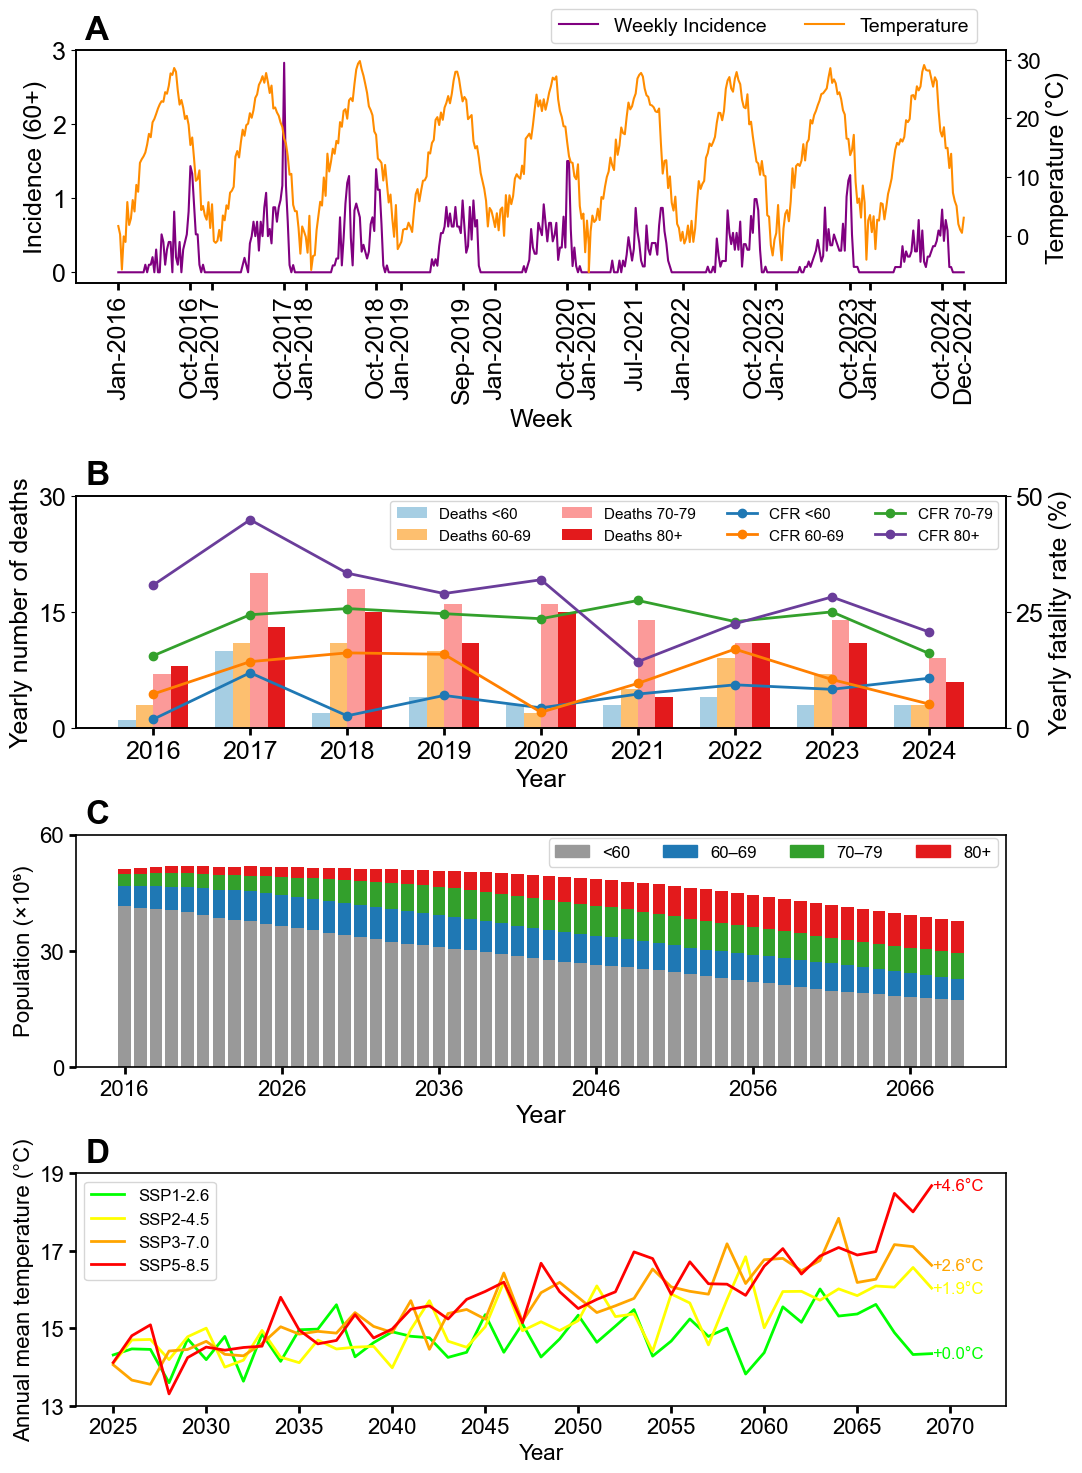

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm
from matplotlib import rcParams
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 🔹 폰트 설정
rcParams['font.family'] = 'Arial'
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.linewidth'] = 1.2

# 🔹 A 그래프용 데이터 로딩
data['Year_Week'] = data['Year'].astype(str) + '-' + data['Week'].astype(str)
data['Year_Week'] = pd.to_datetime(data['Year_Week'] + '-1', format='%Y-%W-%w')
filtered_data = data[data['Year'] >= 2016]

# 🔹 C 패널용 인구 데이터 불러오기
file_path = "./Data/전국미래인구 데이터.xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1')
filtered_df = df[(df['year'] >= 2016) & (df['year'] <= 2069)]

# 🔹 C 패널용 데이터 준비
years = filtered_df['year'].tolist()
pop_total = (filtered_df['Population'] / 1_000_000).tolist()
ratio_60_70 = (filtered_df['60~70세 비율(%)'] * 100).tolist()
ratio_70_80 = (filtered_df['70~80세 비율(%)'] * 100).tolist()
ratio_80_plus = (filtered_df['80세 이상 비율(%)'] * 100).tolist()

def get_xticks_for_mixed(df, case_col='Cases_60', temp_col='tem'):
    ticks, labels = [], []
    df = df[df['Year'] >= 2016]
    for year in df['Year'].unique():
        year_data = df[df['Year'] == year]
        start_date = year_data.iloc[0]['Year_Week']
        ticks.append(start_date)
        labels.append(f"{start_date.strftime('%b')}-{year}")
        peak_idx_case = year_data[case_col].idxmax()
        peak_date_case = df.loc[peak_idx_case, 'Year_Week']
        ticks.append(peak_date_case)
        labels.append(f"{peak_date_case.strftime('%b')}-{year}")
        if year == 2024:
            end_date = year_data.iloc[-1]['Year_Week']
            ticks.append(end_date)
            labels.append(f"{end_date.strftime('%b')}-{year}")
    return ticks, labels

ticks, labels = get_xticks_for_mixed(filtered_data)

# 🔹 사망자, 인구, RCP, SSP 데이터는 이미 불러왔다고 가정

fig = plt.figure(figsize=(12, 22), dpi=100)
gs = gridspec.GridSpec(
    6, 2,
    height_ratios=[1, 0.0000000000000000000000000000000000000000000000000000000000000000000001, 1, 1, 1, 1],
    width_ratios=[1, 1],
    hspace=0.55
)

# 🔸 A
ax_a = fig.add_subplot(gs[0, :])
ax_a.set_facecolor('white')
line1 = ax_a.plot(filtered_data['Year_Week'], filtered_data['Incidence_60'], linestyle='-', color='purple', label='Weekly Incidence')
ax_a.set_xlabel('Week', fontsize=18)
ax_a.set_ylabel('Incidence (60+)', fontsize=18)
ax_a.tick_params(axis='y', labelsize=18)
ax_a.set_xticks(ticks)
ax_a.set_yticks(range(0, 4, 1))
ax_a.set_xticklabels(labels, rotation=90, fontsize=13, ha='center')
ax_a.tick_params(axis='x', labelsize=18)
ax_a.tick_params(axis='x', bottom=True, length=5, width=2, color='black')
ax_a.yaxis.grid(False)

ax2 = ax_a.twinx()
line2 = ax2.plot(filtered_data['Year_Week'], filtered_data['tem'], linestyle='-', color='darkorange', label='Temperature')
ax2.set_ylabel('Temperature (°C)', fontsize=18)
ax2.tick_params(axis='y', labelsize=16)
ax2.yaxis.grid(False)

lines = line1 + line2
labels_ = [l.get_label() for l in lines]
ax_a.legend(lines, labels_, loc='upper center', bbox_to_anchor=(0.74, 1.22), ncol=2, fontsize=14, frameon=True, facecolor='white')
ax_a.text(0.01, 1.05, 'A', transform=ax_a.transAxes, weight='bold', size=24)

# 🔸 B
ax_b = fig.add_subplot(gs[2, :])
ax_b.set_facecolor('white')
ax_b2 = ax_b.twinx()
x = np.arange(len(years2))
bar_width = 0.18
bar_colors = ['#a6cee3', '#fdbf6f', '#fb9a99', '#e31a1c']
line_colors = ['#1f78b4', '#ff7f00', '#33a02c', '#6a3d9a']
label_map = {
    '<60': '<60',
    '60–69': '60-69',
    '70–79': '70-79',
    '≥80': '80+'
}
for i, ag in enumerate(age_groups):
    label_name = label_map.get(ag, ag)
    bars = ax_b.bar(x + i * bar_width, death_counts[ag], width=bar_width,
                    color=bar_colors[i], label=f'Deaths {label_name}',
                    edgecolor='none', zorder=2)
    for bar in bars:
        bar.set_linewidth(0)
for i, ag in enumerate(age_groups):
    label_name = label_map.get(ag, ag)
    ax_b2.plot(x + 1.5 * bar_width, cfr_rates[ag],
               label=f'CFR {label_name}', color=line_colors[i],
               marker='o', linewidth=2, zorder=3)
ax_b.set_xticks(x + 1.5 * bar_width)
ax_b.set_xticklabels(years2, fontsize=18)
ax_b.set_ylabel('Yearly number of deaths', fontsize=18)
ax_b.set_xlabel('Year', fontsize=18)
ax_b2.set_ylabel('Yearly fatality rate (%)', fontsize=18)
ax_b.set_ylim(0, 30)
ax_b.set_yticks(range(0, 31, 15))
ax_b2.set_ylim(0, 50)
ax_b2.set_yticks(range(0, 51, 25))
ax_b.tick_params(axis='y', labelsize=18)
ax_b2.tick_params(axis='y', labelsize=18)
ax_b.tick_params(axis='x', bottom=True, length=5, width=2, color='black')
ax_b.yaxis.grid(False)
ax_b2.yaxis.grid(False)
lines, labels_ = ax_b.get_legend_handles_labels()
lines2, labels2 = ax_b2.get_legend_handles_labels()
ax_b.legend(lines + lines2, labels_ + labels2, fontsize=11, bbox_to_anchor=(1.0, 1.01), loc='upper right', ncol=4, frameon=True, facecolor='white')
ax_b.text(0.01, 1.05, 'B', transform=ax_b.transAxes, weight='bold', size=24)
# 🔸 C 패널 (수정된 누적 막대 그래프: 전체 인구 구성 시각화)
ax_c = fig.add_subplot(gs[3, :])
ax_c.set_facecolor('white')

# 인구 단위 백만
pop_under_60 = (filtered_df['Population_0_60']) / 1_000_000
pop_60_69 = (filtered_df['Population_60_70']) / 1_000_000
pop_70_79 = (filtered_df['Population_70_80']) / 1_000_000
pop_80_plus = (filtered_df['Population_80']) / 1_000_000
years = filtered_df['year']

# 누적 막대그래프 순서: 60세 미만 → 60–69세 → 70–79세 → 80세 이상
bar1 = ax_c.bar(years, pop_under_60, color='#999999', label='<60', width=0.8, zorder=1)
bar2 = ax_c.bar(years, pop_60_69, bottom=pop_under_60, color='#1f78b4', label='60–69', width=0.8, zorder=1)
bottom2 = pop_under_60 + pop_60_69
bar3 = ax_c.bar(years, pop_70_79, bottom=bottom2, color='#33a02c', label='70–79', width=0.8, zorder=1)
bottom3 = bottom2 + pop_70_79
bar4 = ax_c.bar(years, pop_80_plus, bottom=bottom3, color='#e31a1c', label='80+', width=0.8, zorder=1)

# y축 설정
ax_c.set_ylabel('Population (×10⁶)', fontsize=16)
ax_c.set_ylim(0, np.max(bottom3 + pop_80_plus)*1.1)
ax_c.set_xlabel('Year', fontsize=18)
ax_c.set_xticks(range(2016, 2070, 10))
ax_c.tick_params(axis='x', labelsize=16)
ax_c.tick_params(axis='y', labelsize=16)
ax_c.tick_params(axis='x', bottom=True, length=5, width=2, color='black')
ax_c.tick_params(axis='y', left=True, length=5, width=2, color='black')
ax_c.set_ylim(0, 60)
ax_c.set_yticks(range(0, 61, 30))
ax_c.text(0.01, 1.05, 'C', transform=ax_c.transAxes, weight='bold', size=24)
ax_c.yaxis.grid(False)


# 범례 다시 설정
handles_left = [
    Patch(color='#999999', label='<60'),
    Patch(color='#1f78b4', label='60–69'),
    Patch(color='#33a02c', label='70–79'),
    Patch(color='#e31a1c', label='80+'),
]
labels_left = [h.get_label() for h in handles_left]
ax_c.legend(handles_left, labels_left,
            fontsize=12, loc='upper right', bbox_to_anchor=(1.00, 1.02),
            frameon=True, facecolor='white', ncol=4)

# 🔸 D (선 그래프 새 코드)
file_paths = {
    'SSP1-2.6': './Data/SSP126_monthly_avg.xlsx',
    'SSP2-4.5': './Data/SSP245_monthly_avg.xlsx',
    'SSP3-7.0': './Data/SSP370_monthly_avg.xlsx',
    'SSP5-8.5': './Data/SSP585_monthly_avg.xlsx',
}
scenario_yearly_avg = {}
for scenario, path in file_paths.items():
    df = pd.read_excel(path)
    df = df[(df['Year'] >= 2025) & (df['Year'] <= 2069)]
    yearly_avg = df.groupby('Year')['tem'].mean().reset_index()
    scenario_yearly_avg[scenario] = yearly_avg

ax_d = fig.add_subplot(gs[4, :])
colors = {
    'SSP1-2.6': '#00FF00',
    'SSP2-4.5': '#FFFF00',
    'SSP3-7.0': '#FFA500',
    'SSP5-8.5': '#FF0000'
}
for scenario, data_temp in scenario_yearly_avg.items():
    ax_d.plot(data_temp['Year'], data_temp['tem'], label=scenario, color=colors[scenario], linewidth=2)
    temp_start = data_temp[data_temp['Year'] == 2025]['tem'].values[0]
    temp_end = data_temp[data_temp['Year'] == 2069]['tem'].values[0]
    temp_diff = temp_end - temp_start
    ax_d.text(2069, temp_end, f"+{temp_diff:.1f}°C", color=colors[scenario], fontsize=12, va='center')

ax_d.set_xlim(2023, 2073)
ax_d.set_ylim(13, 19)
ax_d.set_xticks(range(2025, 2071, 5))
ax_d.set_yticks(range(13, 20, 2))
ax_d.set_xlabel('Year', fontsize=16)
ax_d.set_ylabel('Annual mean temperature (°C)', fontsize=16)
ax_d.text(0.01, 1.05, 'D', transform=ax_d.transAxes, weight='bold', size=24)
ax_d.tick_params(axis='x', bottom=True, length=5, width=2, color='black')
ax_d.tick_params(axis='y', left=True, length=5, width=2, color='black')
ax_d.tick_params(axis='x', labelsize=16)
ax_d.tick_params(axis='y', labelsize=16)
ax_d.legend(facecolor='white', fontsize=12)
ax_d.set_facecolor('white')
# plt.savefig("C:\\Users\\user\\Dropbox\\CNN_LSTM\\Submission\\Figure\\Figure_2.png", dpi=550)  # 🔹 고해상도 저장
plt.show()

In [53]:
train_cases = pd.DataFrame(columns=machine_values)
test_cases = pd.DataFrame(columns=machine_values)

In [54]:
with torch.no_grad():
    for i in machine_values:
        train_cases[i] = globals()['{}_pred_train'.format(i)]

In [55]:
with torch.no_grad():
    for i in machine_values:
        test_cases[i] = globals()['{}_pred_test'.format(i)]

C:\Users\yogof\AppData\Local\Temp\ipykernel_35180\2506843320.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.42691906e-04  1.67178486e-03 -1.12834666e-03  1.69616062e-04
 -5.14368200e-03 -3.14990766e-03  4.69162140e-03 -1.94461640e-03
 -1.61797736e-03  4.83130141e-03 -6.02224838e-03 -2.86524136e-03
 -1.36716672e-04  4.31972743e-03  2.03826527e-03  9.69412384e-01
  2.79276780e-03  9.92775877e-01  9.99202976e-01  2.00494101e+00
  2.97723058e-02  2.98158056e+00  3.64143913e-02  1.61586234e-01
  4.94555254e+00  3.96115808e+00  1.12674901e+00  2.98879363e+00
  3.99707113e+00  4.00401073e+00  1.74108149e-01  7.90511348e+00
  2.05826235e+00  1.01238266e+00  3.97046764e+00  7.88106043e-02
  2.99851528e+00  3.98682637e+00  4.99968251e+00  8.00314901e+00
  1.39739649e+01  1.28748981e+01  8.96375168e+00  4.97086919e+00
  4.88301217e+00  9.97709940e-01  1.54446561e-02  9.46773684e-01
  1.07244575e-03  4.655

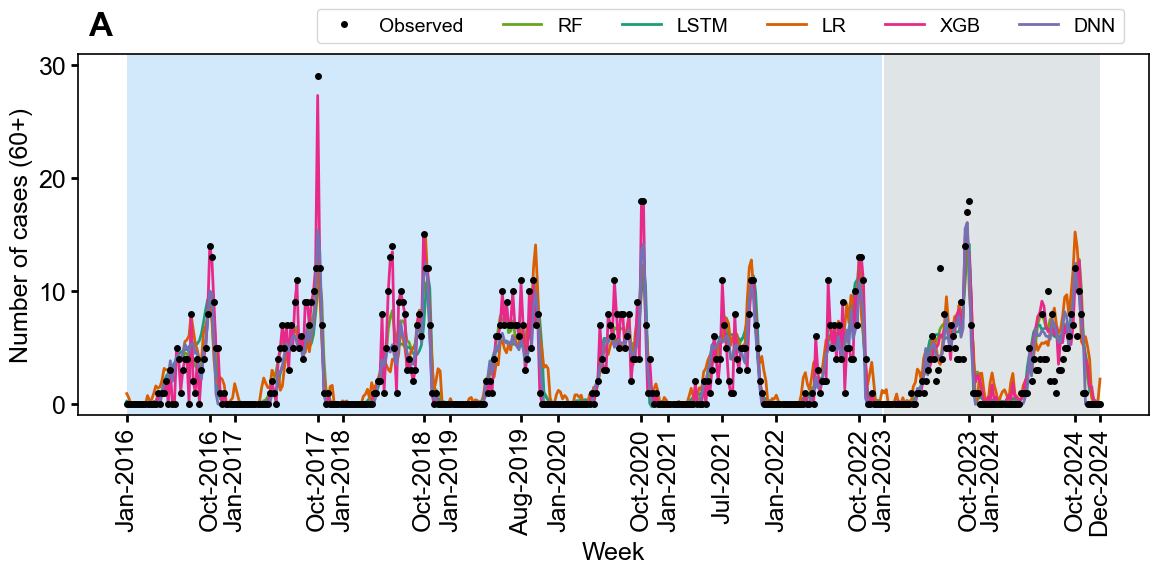

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 🔹 폰트 설정
rcParams['font.family'] = 'Arial'

# 🔹 B plot 데이터 로드
y_all = data.loc[157:,['Year','Cases_60']]
y_all.index = range(len(y_all))

pred_all = pd.concat([train_cases, test_cases], ignore_index=True)
temp_yearW = data.loc[157:,['Year','Week']]
temp_yearW.index=range(len(temp_yearW))
pred_all = pd.concat([temp_yearW, pred_all], axis=1)

for i in machine_values:
    for j in range(2016,2025):
        pred_all.loc[pred_all['Year']==j,i] = (pred_all.loc[pred_all['Year']==j,i] / 1000000) * filtered_df.loc[filtered_df['year']==j,'Population_60'].item()

# 🔹 날짜 생성
def create_start_date_cases(df):
    df['start_date'] = pd.to_datetime(df['Year'].astype(str) + '-1', format='%Y-%w') + pd.to_timedelta((df['Week'] - 1) * 7, unit='D')

create_start_date_cases(pred_all)

def generate_full_ticks(df, observed_df):
    ticks = []
    labels = []
    for year in sorted(df['Year'].unique()):
        if year > 2024:
            continue  # 2024년까지만 눈금 생성

        year_data = df[df['Year'] == year]
        start_index = year_data[year_data['Week'] == 1].index[0]
        ticks.append(start_index)
        labels.append(year_data.loc[start_index, 'start_date'].strftime('%b') + f'-{year}')

        observed_data = observed_df.loc[year_data.index]
        peak_index = observed_data['Cases_60'].idxmax()
        ticks.append(peak_index)
        labels.append(df.loc[peak_index, 'start_date'].strftime('%b') + f'-{year}')

        if year == 2024:
            end_index = year_data.index[-1]
            ticks.append(end_index)
            labels.append(df.loc[end_index, 'start_date'].strftime('%b') + f'-{year}')
    return ticks, labels

xticks_B, xlabels_B = generate_full_ticks(pred_all, y_all)

# 🔹 시각화
fig, ax = plt.subplots(figsize=(12, 6))

# 🔸 배경 영역
train_end_B = len(train_cases) - 1
test_start_B = len(train_cases)
test_end_B = len(train_cases) + len(test_cases) - 1

ax.axvspan(0, train_end_B, facecolor='#90caf9', alpha=0.4, zorder=0)
ax.axvspan(test_start_B, test_end_B, facecolor='#b0bec5', alpha=0.4, zorder=0)

# 🔸 색상 지정
model_colors = {
    'LSTM': '#1b9e77',
    'LR': '#d95f02',
    'DNN': '#7570b3',
    'XGB': '#e7298a',
    'RF': '#66a61e'
}

# 🔸 관측값 (원형 마커로 변경)
ax.plot(y_all.index, y_all['Cases_60'], 'o', label='Observed', color='black', markersize=4, zorder=3)

# 🔸 예측값
for model in ['RF', 'LSTM', 'LR', 'XGB', 'DNN']:
    ax.plot(pred_all.index, pred_all[model], label=model, color=model_colors[model], linewidth=2, zorder=2)

# 🔸 설정
ax.set_ylim(-1, 31)
ax.set_yticks(range(0, 31, 10))
ax.set_ylabel('Number of cases (60+)', fontsize=18)
ax.set_xlabel('Week', fontsize=18)
ax.tick_params(labelsize=16)
ax.legend(fontsize=14, ncol=6, bbox_to_anchor=(0.60, 1.15), loc='upper center', facecolor='white')
ax.set_facecolor('white')
ax.set_xticks(xticks_B)
ax.set_xticklabels(xlabels_B, fontsize=14, rotation=90)
ax.tick_params(axis='x', bottom=True, length=5, width=2, color='black')
ax.tick_params(axis='y', left=True, length=5, width=2, color='black')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.text(0.01, 1.05, 'A', transform=ax.transAxes, weight='bold', size=24)
ax.yaxis.grid(False)
ax.xaxis.grid(False)

# 🔸 출력
plt.tight_layout()
# plt.savefig("C:\\Users\\user\\Dropbox\\CNN_LSTM\\Submission\\Figure\\Figure_3.png", dpi=1050)
plt.show()


In [57]:
data_tick = pd.read_excel('./Data/tick_data.xlsx')

In [58]:
start_year_tick = 2016
end_year_tick = 2023

data_train_tick = data_tick[(data_tick['year']>=start_year_tick) & (data_tick['year']<end_year_tick)]
data_test_tick = data_tick[data_tick['year']>=end_year_tick]

In [59]:
data_train_tick.index = range(len(data_train_tick))
data_test_tick.index = range(len(data_test_tick))

In [60]:
features_tick = ['maxtem', 'mintem','tem','rain', 'hum']

In [61]:
target_tick = 'density'

In [62]:
X_tick = pd.concat([data_train_tick.loc[:, features_tick],data_test_tick.loc[:, features_tick]])
Y_tick = pd.concat([data_train_tick[target_tick],data_test_tick[target_tick]])
X_tick.index=range(len(X_tick))
Y_tick.index=range(len(Y_tick))

In [63]:
X_tick_max = X_tick.max()
X_tick_min = X_tick.min()
X_tick_s = (X_tick-X_tick_min)/(X_tick_max-X_tick_min)

Y_tick_max = Y_tick.max()
Y_tick_min = Y_tick.min()
Y_tick_s = (Y_tick-Y_tick_min)/(Y_tick_max-Y_tick_min)

In [64]:
window_size_tick = 4

In [65]:
train_num_tick = 84-window_size_tick+1

In [66]:
temp_X = X_tick_s.copy()
temp_Y = Y_tick_s.copy()
    
temp_X_w, temp_Y_w = make_dataset_D(temp_X, temp_Y, window_size_tick)
temp_X_w_1 = temp_X_w.reshape(temp_X_w.shape[0],-1)

X_train_tick = temp_X_w_1[:train_num_tick]
X_test_tick = temp_X_w_1[train_num_tick:]

y_train_tick = temp_Y_w[:train_num_tick]
y_test_tick = temp_Y_w[train_num_tick:]

In [67]:
LR_model_tick = joblib.load('LR_model_tick.pkl')
RF_model_tick = joblib.load('rf_model_tick.pkl')
XGB_model_tick = joblib.load('xgb_model_tick.pkl')

In [68]:
LR_pred_train_tick = LR_model_tick.predict(X_train_tick)
LR_pred_test_tick = LR_model_tick.predict(X_test_tick)
LR_pred_train_tick = np.maximum(0, LR_pred_train_tick)
LR_pred_test_tick = np.maximum(0, LR_pred_test_tick)

RF_pred_train_tick = RF_model_tick.predict(X_train_tick)
RF_pred_test_tick = RF_model_tick.predict(X_test_tick)

XGB_pred_train_tick = XGB_model_tick.predict(X_train_tick)
XGB_pred_test_tick = XGB_model_tick.predict(X_test_tick)

In [69]:
X_train_D_tick = torch.Tensor(np.array(X_train_tick))
X_test_D_tick = torch.Tensor(np.array(X_test_tick))

y_train_D_tick = torch.Tensor(np.array(y_train_tick))
y_test_D_tick = torch.Tensor(np.array(y_test_tick))

In [70]:
class Net_tick(nn.Module):
    def __init__(self):
        super().__init__()

        # 은닉층 정의(은닉층 노드 수 : n_hidden)
        self.l1 = nn.Linear(len(features_tick)*window_size_tick, 32)

        # 출력층 정의
        self.l2 = nn.Linear(32, 16)
        self.l3 = nn.Linear(16, 8)
        self.l4 = nn.Linear(8, 1)

        # ReLU 함수 정의
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.l4(x)
        # x = self.dropout(x)
        # x = self.relu(x)
        x = x.reshape(-1)
        return x

In [71]:
model_tick = Net_tick()

state_dict = torch.load('DNN_model_tick.pth', weights_only=True)
model_tick.load_state_dict(state_dict)
model_tick.eval()

DNN_pred_train_tick = model_tick(X_train_D_tick)
DNN_pred_test_tick = model_tick(X_test_D_tick)

In [72]:
DNN_pred_train_tick = torch.clamp(DNN_pred_train_tick, min=0)
DNN_pred_test_tick = torch.clamp(DNN_pred_test_tick, min=0)

In [73]:
X_w, Y_w = make_dataset_D(X_tick_s, Y_tick_s, window_size_tick)

X_train_tick_L = torch.Tensor(X_w[:train_num_tick])
X_test_tick_L = torch.Tensor(X_w[train_num_tick:])

y_train_tick_L = torch.Tensor(Y_w[:train_num_tick]).reshape(-1,1)
y_test_tick_L = torch.Tensor(Y_w[train_num_tick:]).reshape(-1,1)

In [74]:
num_layer=2
hidden_num = 64

class LSTM_tick(nn.Module):
    def __init__(self):
        super(LSTM_tick, self).__init__()

        self.lstm = nn.LSTM(input_size = len(features_tick), hidden_size=hidden_num, num_layers=num_layer,
                          batch_first = True)

        self.fc1 = nn.Linear(in_features=hidden_num, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):

        h0 = torch.zeros(num_layer, x.shape[0], hidden_num)
        c0 = torch.zeros(num_layer, x.shape[0], hidden_num)

        x, hn = self.lstm(x, (h0,c0))

        x = x[:, -1, :]

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [75]:
model_tick_L = LSTM_tick()

state_dict = torch.load('LSTM_model_tick.pth', weights_only=True)
model_tick_L.load_state_dict(state_dict)
model_tick_L.eval()

LSTM_pred_train_tick = model_tick_L(X_train_tick_L)
LSTM_pred_test_tick = model_tick_L(X_test_tick_L)

In [76]:
from sklearn.metrics import r2_score

In [77]:
for i in machine_values:
    globals()['{}_pred_train_tick'.format(i)] = globals()['{}_pred_train_tick'.format(i)]*(Y_tick_max-Y_tick_min)+Y_tick_min
    globals()['{}_pred_test_tick'.format(i)] = globals()['{}_pred_test_tick'.format(i)]*(Y_tick_max-Y_tick_min)+Y_tick_min

In [78]:
y_train_tick = y_train_tick*(Y_tick_max-Y_tick_min)+Y_tick_min
y_test_tick = y_test_tick*(Y_tick_max-Y_tick_min)+Y_tick_min

In [79]:
Result_ACC_reg_tick=pd.DataFrame(columns=['Estimator','train_MSE','test_MSE','train_R2','test_R2'])

In [80]:
with torch.no_grad():
    num=0
    for i in machine_values:
        Result_ACC_reg_tick.loc[num,'Estimator']=i
        Result_ACC_reg_tick.loc[num,'train_MSE']=mean_squared_error(y_train_tick,globals()['{}_pred_train_tick'.format(i)])
        Result_ACC_reg_tick.loc[num,'test_MSE']=mean_squared_error(y_test_tick,globals()['{}_pred_test_tick'.format(i)])
        Result_ACC_reg_tick.loc[num,'train_R2']=r2_score(y_train_tick, globals()['{}_pred_train_tick'.format(i)])
        Result_ACC_reg_tick.loc[num,'test_R2']=r2_score(y_test_tick, globals()['{}_pred_test_tick'.format(i)])
        num=num+1

In [81]:
Result_ACC_reg_tick

,Estimator,train_MSE,test_MSE,train_R2,test_R2
0,LR,423.558385,404.320624,0.712342,0.508776
1,RF,319.722102,296.339999,0.782862,0.639966
2,XGB,100.585722,164.398908,0.931688,0.800266
3,DNN,188.148492,76.433865,0.87222,0.907138
4,LSTM,497.530711,229.85794,0.662104,0.720737


In [82]:
SSP126_data = pd.read_excel('./Data/SSP126_weekly.xlsx')
SSP245_data = pd.read_excel('./Data/SSP245_weekly.xlsx')
SSP370_data = pd.read_excel('./Data/SSP370_weekly.xlsx')
SSP585_data = pd.read_excel('./Data/SSP585_weekly.xlsx')

In [83]:
SSP_start_year = 2024
SSP_end_year = 2070

In [84]:
# 🔹 2024년 50주차 이상부터 포함되도록 조건 추가
SSP126_data = SSP126_data[
    ((SSP126_data['year'] > SSP_start_year) |
     ((SSP126_data['year'] == SSP_start_year) & (SSP126_data['week'] >= 48))) &
    (SSP126_data['year'] <= SSP_end_year)
]

SSP245_data = SSP245_data[
    ((SSP245_data['year'] > SSP_start_year) |
     ((SSP245_data['year'] == SSP_start_year) & (SSP245_data['week'] >= 48))) &
    (SSP245_data['year'] <= SSP_end_year)
]

SSP370_data = SSP370_data[
    ((SSP370_data['year'] > SSP_start_year) |
     ((SSP370_data['year'] == SSP_start_year) & (SSP370_data['week'] >= 48))) &
    (SSP370_data['year'] <= SSP_end_year)
]

SSP585_data = SSP585_data[
    ((SSP585_data['year'] > SSP_start_year) |
     ((SSP585_data['year'] == SSP_start_year) & (SSP585_data['week'] >= 48))) &
    (SSP585_data['year'] <= SSP_end_year)
]

# 🔹 인덱스 재설정
SSP126_data.index = range(len(SSP126_data))
SSP245_data.index = range(len(SSP245_data))
SSP370_data.index = range(len(SSP370_data))
SSP585_data.index = range(len(SSP585_data))

In [85]:
SSP126_data

,year,week,hum,rain,tem
0,2024,48,70.93,0.29,9.39
1,2024,49,67.38,0.83,6.83
2,2024,50,57.39,0.74,0.57
3,2024,51,68.10,1.32,3.55
4,2024,52,64.67,0.27,3.85
...,...,...,...,...,...
2392,2070,48,66.91,1.05,2.64
2393,2070,49,63.61,2.00,4.76
2394,2070,50,60.63,0.91,0.47
2395,2070,51,52.45,0.15,-0.17


In [86]:
chuseok_dates.rename(columns={'date': 'Chuseok_Date'}, inplace=True)
# 'Chuseok_Date' 열을 datetime 형식으로 변환
chuseok_dates['Chuseok_Date'] = pd.to_datetime(chuseok_dates['Chuseok_Date'], format='%Y-%m-%d')

# 2014년부터 2023년까지의 데이터만 필터링
chuseok_dates = chuseok_dates[chuseok_dates['Chuseok_Date'].dt.year.between(2024, 2070)]

# 결과 확인
print(chuseok_dates[['Chuseok_Date']])

   Chuseok_Date
10   2024-09-17
11   2025-10-06
12   2026-09-25
13   2027-09-15
14   2028-10-03
15   2029-09-22
16   2030-09-12
17   2031-10-01
18   2032-09-19
19   2033-09-08
20   2034-09-27
21   2035-09-16
22   2036-10-04
23   2037-09-24
24   2038-09-13
25   2039-10-02
26   2040-09-21
27   2041-09-10
28   2042-09-28
29   2043-09-17
30   2044-10-05
31   2045-09-25
32   2046-09-15
33   2047-10-04
34   2048-09-22
35   2049-09-11
36   2050-09-30
37   2051-09-19
38   2052-09-07
39   2053-09-26
40   2054-09-16
41   2055-10-05
42   2056-09-24
43   2057-09-13
44   2058-10-02
45   2059-09-21
46   2060-09-09
47   2061-09-28
48   2062-09-17
49   2063-10-06
50   2064-09-25
51   2065-09-15
52   2066-10-03
53   2067-09-23
54   2068-09-11
55   2069-09-29
56   2070-09-19


In [87]:
# 주(week)와 연도를 추가
chuseok_dates['Year'] = chuseok_dates['Chuseok_Date'].dt.year
chuseok_dates['Week'] = chuseok_dates['Chuseok_Date'].dt.isocalendar().week

# 결과 확인
print(chuseok_dates[['Chuseok_Date', 'Year', 'Week']])

   Chuseok_Date  Year  Week
10   2024-09-17  2024    38
11   2025-10-06  2025    41
12   2026-09-25  2026    39
13   2027-09-15  2027    37
14   2028-10-03  2028    40
15   2029-09-22  2029    38
16   2030-09-12  2030    37
17   2031-10-01  2031    40
18   2032-09-19  2032    38
19   2033-09-08  2033    36
20   2034-09-27  2034    39
21   2035-09-16  2035    37
22   2036-10-04  2036    40
23   2037-09-24  2037    39
24   2038-09-13  2038    37
25   2039-10-02  2039    39
26   2040-09-21  2040    38
27   2041-09-10  2041    37
28   2042-09-28  2042    39
29   2043-09-17  2043    38
30   2044-10-05  2044    40
31   2045-09-25  2045    39
32   2046-09-15  2046    37
33   2047-10-04  2047    40
34   2048-09-22  2048    39
35   2049-09-11  2049    36
36   2050-09-30  2050    39
37   2051-09-19  2051    38
38   2052-09-07  2052    36
39   2053-09-26  2053    39
40   2054-09-16  2054    38
41   2055-10-05  2055    40
42   2056-09-24  2056    38
43   2057-09-13  2057    37
44   2058-10-02  205

In [88]:
def add_chuseok_flag_to_weekly_data(weekly_data, chuseok_dates):
    # Chuseok_Flag 열 추가 및 초기화
    weekly_data['Chuseok_Flag'] = 0

    # 각 연도의 추석 주를 기준으로 전후 범위 설정 (추석 전 2주, 추석 후 4주)
    for _, row in chuseok_dates.iterrows():
        chuseok_year = row['Year']
        chuseok_week = row['Week']
        
        # 추석 전 2주 및 추석 후 4주 주 번호 계산
        start_week = chuseok_week - 2
        end_week = chuseok_week + 2

        # 플래그 설정 (연도 경계 고려)
        weekly_data.loc[
            ((weekly_data['year'] == chuseok_year) & (weekly_data['week'].between(start_week, end_week))) |
            ((weekly_data['year'] == chuseok_year - 1) & (start_week < 1) & (weekly_data['week'] > 50)) |
            ((weekly_data['year'] == chuseok_year + 1) & (end_week > 52) & (weekly_data['week'] < 7)),
            'Chuseok_Flag'
        ] = 1

    return weekly_data

In [89]:
# 추석 플래그 추가
SSP126_data = add_chuseok_flag_to_weekly_data(SSP126_data, chuseok_dates)
SSP245_data = add_chuseok_flag_to_weekly_data(SSP245_data, chuseok_dates)
SSP370_data = add_chuseok_flag_to_weekly_data(SSP370_data, chuseok_dates)
SSP585_data = add_chuseok_flag_to_weekly_data(SSP585_data, chuseok_dates)

In [90]:
SSP126_data

,year,week,hum,rain,tem,Chuseok_Flag
0,2024,48,70.93,0.29,9.39,0
1,2024,49,67.38,0.83,6.83,0
2,2024,50,57.39,0.74,0.57,0
3,2024,51,68.10,1.32,3.55,0
4,2024,52,64.67,0.27,3.85,0
...,...,...,...,...,...,...
2392,2070,48,66.91,1.05,2.64,0
2393,2070,49,63.61,2.00,4.76,0
2394,2070,50,60.63,0.91,0.47,0
2395,2070,51,52.45,0.15,-0.17,0


In [91]:
# 주별 등산객 데이터 파일 경로
weekly_hiker_data_path = "./Data/Weekly_hiker_data.xlsx"

# 기존 주별 데이터 불러오기
weekly_data = pd.read_excel(weekly_hiker_data_path)

In [92]:
def add_weekly_hiker_to_existing_data(original_weekly_data, new_weekly_data):
    # 컬럼명을 소문자로統一
    new_weekly_data.rename(columns={"Year": "year", "Week": "week", "Weekly_hiker" : "Weekly hiker"}, inplace=True)
    # 필요한 열만 선택하여 병합 (Year, Week 기준)
    new_weekly_data = new_weekly_data[["year", "week", "Weekly hiker"]]
    
    # 기존 데이터에 새로운 변수 추가 (기존 데이터 유지)
    merged_data = original_weekly_data.merge(new_weekly_data, on=["year", "week"], how="left")

    return merged_data

In [93]:
# 추석 플래그 추가
SSP126_data = add_weekly_hiker_to_existing_data(SSP126_data, weekly_data)
SSP245_data = add_weekly_hiker_to_existing_data(SSP245_data, weekly_data)
SSP370_data = add_weekly_hiker_to_existing_data(SSP370_data, weekly_data)
SSP585_data = add_weekly_hiker_to_existing_data(SSP585_data, weekly_data)

In [94]:
SSP126_data

,year,week,hum,rain,tem,Chuseok_Flag,Weekly hiker
0,2024,48,70.93,0.29,9.39,0,1025704
1,2024,49,67.38,0.83,6.83,0,564928
2,2024,50,57.39,0.74,0.57,0,564928
3,2024,51,68.10,1.32,3.55,0,564928
4,2024,52,64.67,0.27,3.85,0,564928
...,...,...,...,...,...,...,...
2392,2070,48,66.91,1.05,2.64,0,747950
2393,2070,49,63.61,2.00,4.76,0,379330
2394,2070,50,60.63,0.91,0.47,0,379330
2395,2070,51,52.45,0.15,-0.17,0,379330


In [95]:
tick_126 = pd.read_excel("./Data/SSP126_weekly_tick_density_ver3.xlsx")
tick_245 = pd.read_excel("./Data/SSP245_weekly_tick_density_ver3.xlsx")
tick_370 = pd.read_excel("./Data/SSP370_weekly_tick_density_ver3.xlsx")
tick_585 = pd.read_excel("./Data/SSP585_weekly_tick_density_ver3.xlsx")

# 🔹 컬럼 이름 변경
tick_126 = tick_126.rename(columns={'Value': "Tick Density"})
tick_126 = tick_126.rename(columns={'Week': 'week'})
tick_126 = tick_126.rename(columns={'Year': 'year'})
tick_245 = tick_245.rename(columns={'Value': "Tick Density"})
tick_245 = tick_245.rename(columns={'Week': 'week'})
tick_245 = tick_245.rename(columns={'Year': 'year'})
tick_370 = tick_370.rename(columns={'Value': "Tick Density"})
tick_370 = tick_370.rename(columns={'Week': 'week'})
tick_370 = tick_370.rename(columns={'Year': 'year'})
tick_585 = tick_585.rename(columns={'Value': "Tick Density"})
tick_585 = tick_585.rename(columns={'Week': 'week'})
tick_585 = tick_585.rename(columns={'Year': 'year'})

In [96]:
# 🔹 진드기 예측값을 기존 데이터에 병합 (Year, Week 기준)
SSP126_data = pd.merge(SSP126_data, tick_126[['year', 'week', 'Tick Density']], on=['year', 'week'], how='left')
SSP245_data = pd.merge(SSP245_data, tick_245[['year', 'week', 'Tick Density']], on=['year', 'week'], how='left')
SSP370_data = pd.merge(SSP370_data, tick_370[['year', 'week', 'Tick Density']], on=['year', 'week'], how='left')
SSP585_data = pd.merge(SSP585_data, tick_585[['year', 'week', 'Tick Density']], on=['year', 'week'], how='left')

In [97]:
SSP126_data

,year,week,hum,rain,tem,Chuseok_Flag,Weekly hiker,Tick Density
0,2024,48,70.93,0.29,9.39,0,1025704,1.400000
1,2024,49,67.38,0.83,6.83,0,564928,0.000000
2,2024,50,57.39,0.74,0.57,0,564928,0.000000
3,2024,51,68.10,1.32,3.55,0,564928,0.000000
4,2024,52,64.67,0.27,3.85,0,564928,0.000000
...,...,...,...,...,...,...,...,...
2392,2070,48,66.91,1.05,2.64,0,747950,0.117035
2393,2070,49,63.61,2.00,4.76,0,379330,0.117035
2394,2070,50,60.63,0.91,0.47,0,379330,0.117035
2395,2070,51,52.45,0.15,-0.17,0,379330,0.117035


In [98]:
features = ['tem','rain', 'hum', 'Chuseok_Flag', 'Weekly hiker', 'Tick Density']

In [99]:
# 데이터 정규화
X_min_SSP126 = SSP126_data[features].min()
X_max_SSP126 = SSP126_data[features].max()
SSP126_data_s = (SSP126_data[features] - X_min_SSP126) / (X_max_SSP126 - X_min_SSP126)
SSP245_data_s = (SSP245_data[features] - X_min_SSP126) / (X_max_SSP126 - X_min_SSP126)
SSP370_data_s = (SSP370_data[features] - X_min_SSP126) / (X_max_SSP126 - X_min_SSP126)
SSP585_data_s = (SSP585_data[features] - X_min_SSP126) / (X_max_SSP126 - X_min_SSP126)

In [100]:
def make_dataset_with_variable_window(data, features, max_window_size):
    x_data = []

    for i in range(5, len(data)):  # 처음 3개는 제외
        current_window_size = min(i + 1, max_window_size)
        x_window = data.iloc[i + 1 - current_window_size:i + 1][features].values
        x_data.append(
            np.pad(
                x_window,
                ((max_window_size - current_window_size, 0), (0, 0)),  # 앞쪽에 0으로 패딩
                mode='constant',
                constant_values=0
            )
        )

    return np.array(x_data)

# 3차원 데이터를 2차원으로 변환하는 함수 (변경 없음)
def flatten_3d_to_2d(data_3d):
    samples, window_size, features = data_3d.shape
    return data_3d.reshape(samples, window_size * features)

In [102]:
# 윈도우 크기를 최대 4로 설정
max_window_size = 6

# RCP45 데이터셋 생성
SSP126_data_windowed = make_dataset_with_variable_window(SSP126_data_s, features, max_window_size)

SSP245_data_windowed = make_dataset_with_variable_window(SSP245_data_s, features, max_window_size)

SSP370_data_windowed = make_dataset_with_variable_window(SSP370_data_s, features, max_window_size)
# RCP85 데이터셋 생성
SSP585_data_windowed = make_dataset_with_variable_window(SSP585_data_s, features, max_window_size)

# 2차원 데이터 변환
SSP126_data_flattened = flatten_3d_to_2d(SSP126_data_windowed)
SSP245_data_flattened = flatten_3d_to_2d(SSP245_data_windowed)
SSP370_data_flattened = flatten_3d_to_2d(SSP370_data_windowed)
SSP585_data_flattened = flatten_3d_to_2d(SSP585_data_windowed)

In [103]:
SSP126_data_windowed

array([[[0.43447581, 0.00553541, 0.57525454, 0.        , 0.69603019,
         0.01020019],
        [0.36995968, 0.01584272, 0.49667995, 0.        , 0.19985614,
         0.        ],
        [0.21219758, 0.01412483, 0.27556441, 0.        , 0.19985614,
         0.        ],
        [0.28729839, 0.02519565, 0.5126162 , 0.        , 0.19985614,
         0.        ],
        [0.29485887, 0.00515366, 0.43669765, 0.        , 0.19985614,
         0.        ],
        [0.33014113, 0.03378507, 0.50553342, 0.        , 0.04803168,
         0.        ]],

       [[0.36995968, 0.01584272, 0.49667995, 0.        , 0.19985614,
         0.        ],
        [0.21219758, 0.01412483, 0.27556441, 0.        , 0.19985614,
         0.        ],
        [0.28729839, 0.02519565, 0.5126162 , 0.        , 0.19985614,
         0.        ],
        [0.29485887, 0.00515366, 0.43669765, 0.        , 0.19985614,
         0.        ],
        [0.33014113, 0.03378507, 0.50553342, 0.        , 0.04803168,
         0.        

In [104]:
with torch.no_grad():
    SSP126_tensor = torch.tensor(SSP126_data_flattened, dtype=torch.float32)
    SSP245_tensor = torch.tensor(SSP245_data_flattened, dtype=torch.float32)
    SSP370_tensor = torch.tensor(SSP370_data_flattened, dtype=torch.float32)
    SSP585_tensor = torch.tensor(SSP585_data_flattened, dtype=torch.float32)

    pred_SSP126 = DNN_model(SSP126_tensor).detach().numpy()
    pred_SSP245 = DNN_model(SSP245_tensor).detach().numpy()
    pred_SSP370 = DNN_model(SSP370_tensor).detach().numpy()
    pred_SSP585 = DNN_model(SSP585_tensor).detach().numpy()

In [105]:
def relu(x):
    return np.maximum(0, x)

pred_SSP126= relu(pred_SSP126)
pred_SSP245= relu(pred_SSP245)
pred_SSP370= relu(pred_SSP370)
pred_SSP585= relu(pred_SSP585)

In [106]:
# 연도 및 주차 정보 생성: 모든 연도를 1~52주로 구성
years = list(range(2025, 2071))  # 2025년 ~ 2070년
weeks_per_year = 52

# 모든 연도 1~52주로 구성
year_week_list = [(year, week) for year in years for week in range(1, weeks_per_year + 1)]

# 데이터프레임 생성
df_SSP126 = pd.DataFrame(year_week_list, columns=['Year', 'Week'])
df_SSP245 = pd.DataFrame(year_week_list, columns=['Year', 'Week'])
df_SSP370 = pd.DataFrame(year_week_list, columns=['Year', 'Week'])
df_SSP585 = pd.DataFrame(year_week_list, columns=['Year', 'Week'])

# 예측값 할당 (예측 결과는 (n,) 또는 (n,1)이라 가정하고 flatten 적용)
df_SSP126['Prediction'] = pred_SSP126[:len(df_SSP126)].flatten()
df_SSP245['Prediction'] = pred_SSP245[:len(df_SSP245)].flatten()
df_SSP370['Prediction'] = pred_SSP370[:len(df_SSP370)].flatten()
df_SSP585['Prediction'] = pred_SSP585[:len(df_SSP585)].flatten()

In [107]:
pred_SSP126

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [108]:
# Step 1: Load the population data
file_path = './Data/전국미래인구 데이터.xlsx'
population_data = pd.ExcelFile(file_path)
population_df = population_data.parse('Sheet1')
print(type(population_df))
population_df

<class 'pandas.core.frame.DataFrame'>


,year,Population,Population_0,Population_40,Population_0_60,Population_60,Population_70,Population_80,Population_60_70,Population_70_80,60~70세 비율(%),70~80세 비율(%),80세 이상 비율(%),고령층 비율(%)
0,2013,50428893,25487419,16475263,41962682,8466211,4108151,1125228,4358060,2982923,0.514759,0.352333,0.132908,0.167884
1,2014,50746659,25119797,16808515,41928312,8818347,4271397,1209247,4546950,3062150,0.515624,0.347248,0.137129,0.173772
2,2015,51014947,24797275,16925673,41722948,9291999,4435537,1305490,4856462,3130047,0.522650,0.336854,0.140496,0.182143
3,2016,51217803,24489367,16977011,41466378,9751425,4547079,1417791,5204346,3129288,0.533701,0.320906,0.145393,0.190391
4,2017,51361911,24150398,16975085,41125483,10236428,4779541,1528426,5456887,3251115,0.533085,0.317602,0.149312,0.199300
5,2018,51585058,23862545,16967360,40829905,10755153,5009497,1634958,5745656,3374539,0.534224,0.313760,0.152016,0.208494
6,2019,51764822,23519115,16928764,40447879,11316943,5240372,1764631,6076571,3475741,0.536945,0.307127,0.155928,0.218622
7,2020,51836239,23036763,16833239,39870002,11966237,5489635,1890824,6476602,3598811,0.541240,0.300747,0.158013,0.230847
8,2021,51769539,22437233,16697692,39134925,12634614,5674954,2016985,6959660,3657969,0.550841,0.289520,0.159640,0.244055
9,2022,51672569,21842803,16700520,38543323,13129246,5917283,2155978,7211963,3761305,0.549305,0.286483,0.164212,0.254085


In [109]:
# 컬럼명을 모두 문자열로 변환
population_df.columns = [str(col) for col in population_df.columns]

# 컬럼 이름 변경
population_df = population_df.rename(columns={
    'Population_60': 'population_60+'
})

In [110]:
# Convert weekly incidence rates to cases using 60+ population
df_SSP126 = df_SSP126.merge(population_df[['year', 'population_60+']], left_on='Year', right_on='year', how='left')
df_SSP126['Cases'] = df_SSP126['Prediction'] * (df_SSP126['population_60+'] / 1_000_000)
df_SSP126 = df_SSP126.drop(columns=['year','population_60+'])

In [111]:
# Convert weekly incidence rates to cases using 60+ population
df_SSP245 = df_SSP245.merge(population_df[['year', 'population_60+']], left_on='Year', right_on='year', how='left')
df_SSP245['Cases'] = df_SSP245['Prediction'] * (df_SSP245['population_60+'] / 1_000_000)
df_SSP245 = df_SSP245.drop(columns=['year','population_60+'])

In [112]:
df_SSP370 = df_SSP370.merge(population_df[['year', 'population_60+']], left_on='Year', right_on='year', how='left')
df_SSP370['Cases'] = df_SSP370['Prediction'] * (df_SSP370['population_60+'] / 1_000_000)
df_SSP370 = df_SSP370.drop(columns=['year','population_60+'])

In [113]:
df_SSP585 = df_SSP585.merge(population_df[['year', 'population_60+']], left_on='Year', right_on='year', how='left')
df_SSP585['Cases'] = df_SSP585['Prediction'] * (df_SSP585['population_60+'] / 1_000_000)
df_SSP585 = df_SSP585.drop(columns=['year','population_60+'])

In [174]:
df_SSP585

,Year,Week,Prediction,Cases
0,2025,1,0.000000,0.000000
1,2025,2,0.000000,0.000000
2,2025,3,0.000000,0.000000
3,2025,4,0.000000,0.000000
4,2025,5,0.000000,0.000000
...,...,...,...,...
2387,2070,48,0.117843,2.380354
2388,2070,49,0.059741,1.206726
2389,2070,50,0.000000,0.000000
2390,2070,51,0.000000,0.000000


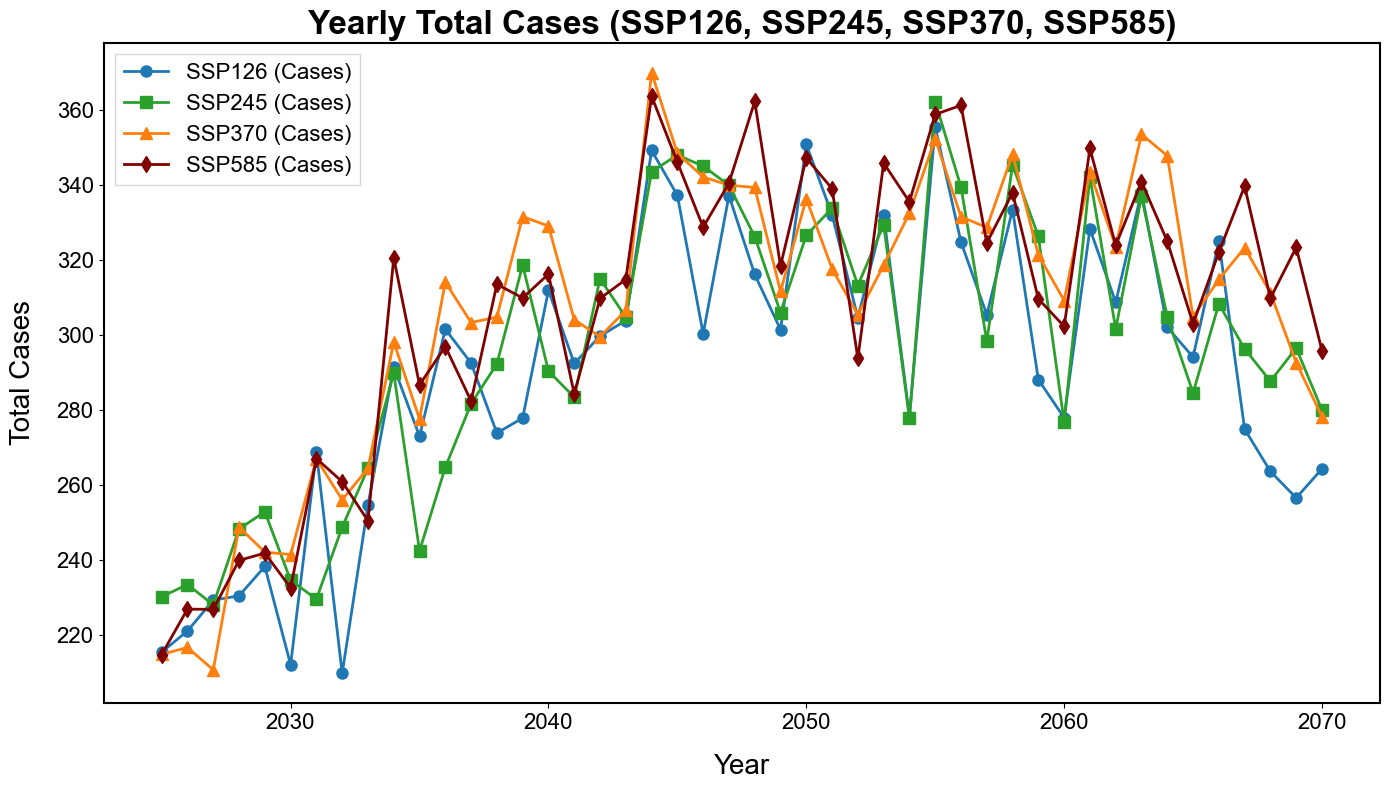

In [115]:
import matplotlib.pyplot as plt

# 🔹 연도별 총합 계산
SSP126_yearly = df_SSP126.groupby('Year')['Cases'].sum()  # df_SSP126의 Cases 총합
SSP245_yearly = df_SSP245.groupby('Year')['Cases'].sum()  # df_SSP245의 Cases 총합
SSP370_yearly = df_SSP370.groupby('Year')['Cases'].sum()  # df_SSP370의 Cases 총합
SSP585_yearly = df_SSP585.groupby('Year')['Cases'].sum()  # df_SSP585의 Cases 총합

# 🔹 연도별 총합을 데이터프레임으로 변환
SSP126_df = SSP126_yearly.reset_index()
SSP245_df = SSP245_yearly.reset_index()
SSP370_df = SSP370_yearly.reset_index()
SSP585_df = SSP585_yearly.reset_index()

ssp126_reg = SSP126_df.copy()
ssp245_reg = SSP245_df.copy()
ssp370_reg = SSP370_df.copy()
ssp585_reg = SSP585_df.copy()
# 🔹 연도별 그래프 생성
plt.figure(figsize=(14, 8))
plt.plot(SSP126_df['Year'], SSP126_df['Cases'], label='SSP126 (Cases)', marker='o', linestyle='-', color='#1f77b4', markersize=8, linewidth=2)
plt.plot(SSP245_df['Year'], SSP245_df['Cases'], label='SSP245 (Cases)', marker='s', linestyle='-', color='#2ca02c', markersize=8, linewidth=2)
plt.plot(SSP370_df['Year'], SSP370_df['Cases'], label='SSP370 (Cases)', marker='^', linestyle='-', color='#ff7f0e', markersize=8, linewidth=2)
plt.plot(SSP585_df['Year'], SSP585_df['Cases'], label='SSP585 (Cases)', marker='d', linestyle='-', color='#800000', markersize=8, linewidth=2)

# 🔹 그래프 설정
plt.title('Yearly Total Cases (SSP126, SSP245, SSP370, SSP585)', fontsize=24, weight='bold')
plt.xlabel('Year', fontsize=20, labelpad=15)
plt.ylabel('Total Cases', fontsize=20, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left', frameon=True, shadow=False, fancybox=False)
plt.gca().set_facecolor('white')  # 내부 배경색 흰색
plt.gca().spines['top'].set_color('black')  # 상단 테두리 검은색
plt.gca().spines['right'].set_color('black')  # 오른쪽 테두리 검은색
plt.gca().spines['bottom'].set_color('black')  # 하단 테두리 검은색
plt.gca().spines['left'].set_color('black')  # 왼쪽 테두리 검은색
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

# 🔹 레이아웃 조정
plt.tight_layout()
plt.show()

In [116]:
extra_week_years = {
    2026, 2027, 2032, 2033, 2037, 2038,
    2043, 2044, 2048, 2049, 2054, 2055,
    2060, 2061, 2065, 2066, 2070
}

# 🔹 5년 단위 평균값 저장할 딕셔너리
SSP126_avg = {}
SSP245_avg = {}
SSP370_avg = {}
SSP585_avg = {}

# 🔹 5년 단위 분석 (2025~2029, ..., 2065~2069)
for start_year in range(2025, 2070, 5):  # 마지막 구간은 2065~2069 (2070 제외됨)
    # 각 구간의 데이터 필터링 (5년 고정)
    SSP126_segment = df_SSP126[(df_SSP126['Year'] >= start_year) & (df_SSP126['Year'] < start_year + 5)]
    SSP245_segment = df_SSP245[(df_SSP245['Year'] >= start_year) & (df_SSP245['Year'] < start_year + 5)]
    SSP370_segment = df_SSP370[(df_SSP370['Year'] >= start_year) & (df_SSP370['Year'] < start_year + 5)]
    SSP585_segment = df_SSP585[(df_SSP585['Year'] >= start_year) & (df_SSP585['Year'] < start_year + 5)]

    # 정확한 연도 수로 나눔 (혹시 누락된 연도가 있을 경우 대비)
    n_years = SSP126_segment['Year'].nunique()
    SSP126_avg[str(start_year)] = SSP126_segment['Cases'].sum() / n_years
    SSP245_avg[str(start_year)] = SSP245_segment['Cases'].sum() / n_years
    SSP370_avg[str(start_year)] = SSP370_segment['Cases'].sum() / n_years
    SSP585_avg[str(start_year)] = SSP585_segment['Cases'].sum() / n_years

In [117]:
# 데이터프레임 생성 및 저장
df_avg = pd.DataFrame({
    'Year': list(SSP126_avg.keys()),
    'SSP126_Avg': list(SSP126_avg.values()),
    'SSP245_Avg': list(SSP245_avg.values()),
    'SSP370_Avg': list(SSP370_avg.values()),
    'SSP585_Avg': list(SSP585_avg.values())
})

In [118]:
data_tick

,year,month,density,tem,maxtem,mintem,hum,rain
0,2016,1,0.0,-0.403752,4.029342,-4.274756,60.178337,29.182878
1,2016,2,0.0,2.260872,7.285974,-2.294465,56.566303,47.425592
2,2016,3,0.0,7.532061,13.239959,2.455084,58.787200,62.488628
3,2016,4,24.8,13.889026,19.872558,8.783904,64.037958,149.281549
4,2016,5,49.7,18.529398,24.587087,12.951048,63.340496,106.669463
...,...,...,...,...,...,...,...,...
103,2024,8,89.8,28.258214,32.937878,24.717530,76.614538,89.689471
104,2024,9,85.2,25.151173,29.847318,21.562127,77.123166,221.323640
105,2024,10,18.2,16.801308,21.713926,12.814019,76.704762,115.744374
106,2024,11,1.4,10.448500,15.909434,5.967117,68.662323,73.348129


C:\Users\yogof\AppData\Local\Temp\ipykernel_35180\43343464.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('Decade')[cases_column].apply(list).to_dict()
C:\Users\yogof\AppData\Local\Temp\ipykernel_35180\43343464.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('Decade')[cases_column].apply(list).to_dict()
C:\Users\yogof\AppData\Local\Temp\ipykernel_35180\43343464.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

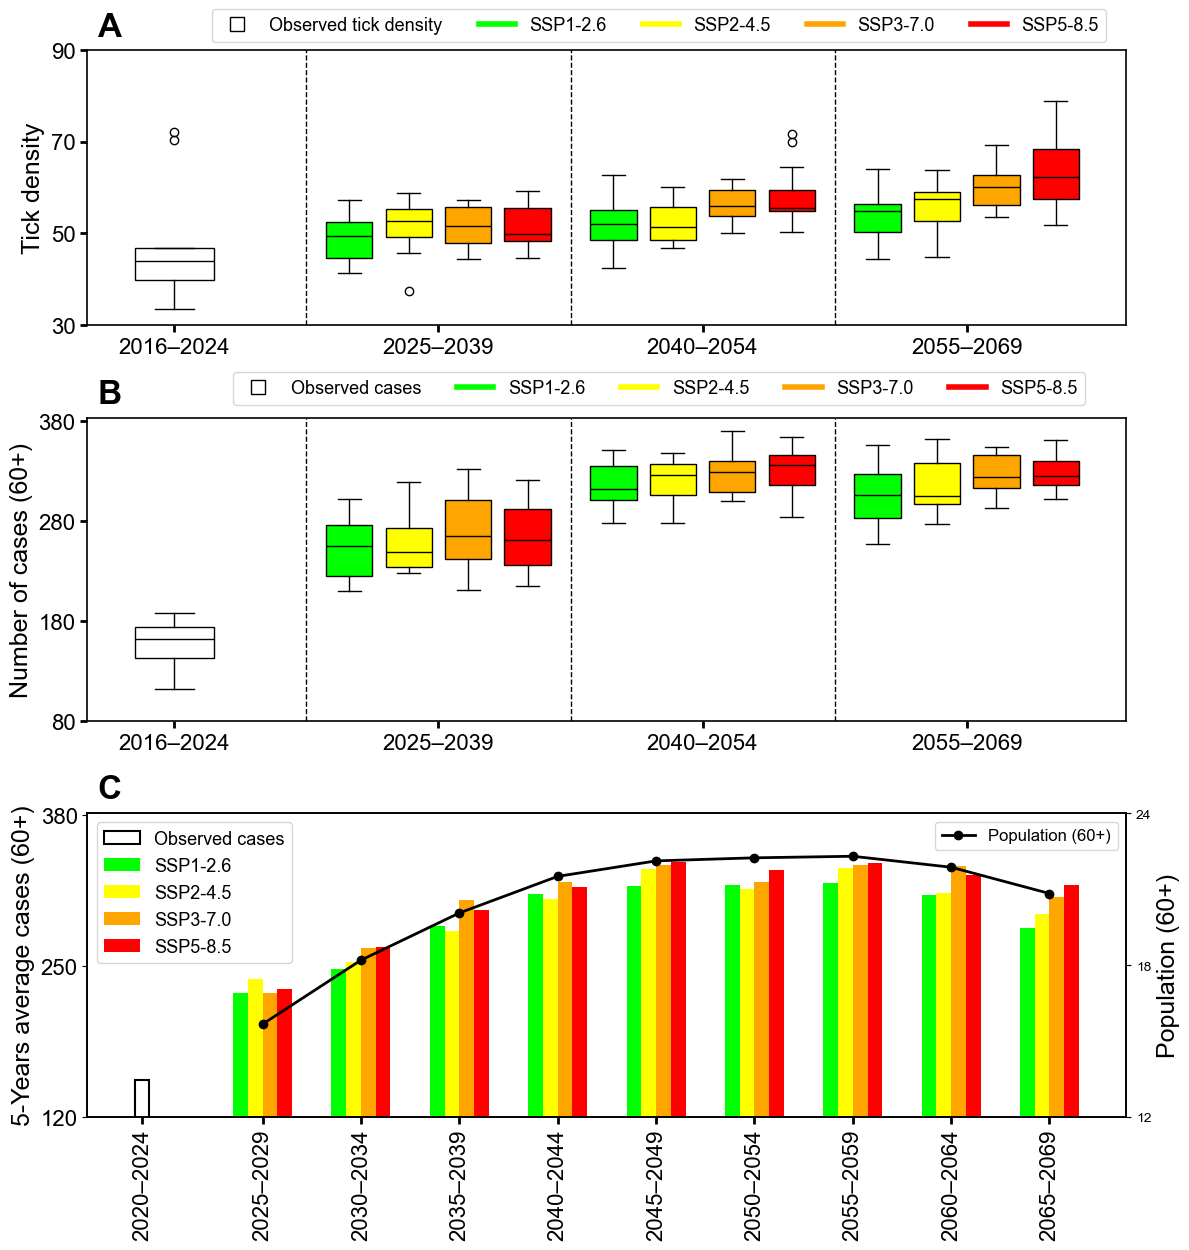

In [119]:
rcParams['font.family'] = 'Arial'
bar_width = 0.15
scenario_colors = ['#00FF00', '#FFFF00', '#FFA500', '#FF0000']
scenario_labels = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
x_centers = [10, 30, 50, 70]
width = 4.5


# Period 함수
def assign_period(year):
    if 2025 <= year <= 2039:
        return '2025–2039'
    elif 2040 <= year <= 2054:
        return '2040–2054'
    elif 2055 <= year <= 2069:
        return '2055–2069'
    return None

# A 패널 데이터 준비
def prepare_tick_df(df, scenario):
    df = df[df['Month'].between(4, 11)].copy()
    df['Scenario'] = scenario
    df['Period'] = df['Year'].apply(assign_period)
    df = df.groupby(['Year', 'Scenario', 'Period'])['Prediction'].mean().reset_index()
    df.rename(columns={'Prediction': 'Yearly_Avg'}, inplace=True)
    return df

obs_df_tick = data_tick[['year','month','density']]
ssp126_tick = pd.read_excel('./Data/SSP126_monthly_진드기_ver3.xlsx')
ssp245_tick = pd.read_excel('./Data/SSP245_monthly_진드기_ver3.xlsx')
ssp370_tick = pd.read_excel('./Data/SSP370_monthly_진드기_ver3.xlsx')
ssp585_tick = pd.read_excel('./Data/SSP585_monthly_진드기_ver3.xlsx')

obs_tick = obs_df_tick[obs_df_tick['month'].between(4, 11)].copy()
obs_tick['Scenario'] = 'Observed'
obs_tick['Period'] = '2016–2024'
obs_tick.rename(columns={'year': 'Year'}, inplace=True)
obs_avg_df = obs_tick.groupby(['Year', 'Scenario', 'Period'])['density'].mean().reset_index()
obs_avg_df.rename(columns={'density': 'Yearly_Avg'}, inplace=True)

tick_df_all = pd.concat([
    obs_avg_df,
    prepare_tick_df(ssp126_tick, 'SSP1-2.6'),
    prepare_tick_df(ssp245_tick, 'SSP2-4.5'),
    prepare_tick_df(ssp370_tick, 'SSP3-7.0'),
    prepare_tick_df(ssp585_tick, 'SSP5-8.5')
], ignore_index=True)

# B, C 패널용 추가 데이터
obs_df_case = data.copy()
ssp126_case = SSP126_df.copy()
ssp245_case = SSP245_df.copy()
ssp370_case = SSP370_df.copy()
ssp585_case = SSP585_df.copy()
data_ssp = df_avg.copy()
pop_df = population_df.copy()

def prepare_decade_data(df, year_column, cases_column):
    df['Decade'] = pd.cut(df[year_column], bins=[2024, 2039, 2054, 2069],
                          labels=['2025–2039', '2040–2054', '2055–2069'])
    return df.groupby('Decade')[cases_column].apply(list).to_dict()

obs_filtered = obs_df_case[(obs_df_case['Year'] >= 2016) & (obs_df_case['Year'] <= 2024)]
observed_cases = obs_filtered.groupby('Year')['Cases_60'].sum().tolist()

ssp126_dec = prepare_decade_data(ssp126_case, 'Year', 'Cases')
ssp245_dec = prepare_decade_data(ssp245_case, 'Year', 'Cases')
ssp370_dec = prepare_decade_data(ssp370_case, 'Year', 'Cases')
ssp585_dec = prepare_decade_data(ssp585_case, 'Year', 'Cases')

cases_data = {
    '2016–2024': [observed_cases],
    '2025–2039': [ssp126_dec.get('2025–2039', []), ssp245_dec.get('2025–2039', []),
                  ssp370_dec.get('2025–2039', []), ssp585_dec.get('2025–2039', [])],
    '2040–2054': [ssp126_dec.get('2040–2054', []), ssp245_dec.get('2040–2054', []),
                  ssp370_dec.get('2040–2054', []), ssp585_dec.get('2040–2054', [])],
    '2055–2069': [ssp126_dec.get('2055–2069', []), ssp245_dec.get('2055–2069', []),
                  ssp370_dec.get('2055–2069', []), ssp585_dec.get('2055–2069', [])]
}

# 인구
pop_filtered = pop_df[(pop_df['year'] >= 2025) & (pop_df['year'] <= 2069)].copy()
pop_filtered['Group'] = (pop_filtered['year'] - 2025) // 5
pop_5yr_avg = pop_filtered.groupby('Group')['population_60+'].mean().reset_index()
pop_5yr_avg['Year'] = pop_5yr_avg['Group'].apply(lambda x: 2025 + x * 5)
pop_5yr_avg['Population_60_M'] = pop_5yr_avg['population_60+'] / 1_000_000

# 시각화
fig = plt.figure(figsize=(12, 13))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1.1, 1.1])
fig.patch.set_facecolor('white')

# A
ax_a = fig.add_subplot(gs[0])
for i, (period, temp_data) in enumerate({
    '2016–2024': ['Observed'],
    '2025–2039': scenario_labels,
    '2040–2054': scenario_labels,
    '2055–2069': scenario_labels
}.items()):
    center = x_centers[i]
    offset = (len(temp_data) - 1) * width / 2
    pos = [center - offset + j * width for j in range(len(temp_data))]
    for j, scenario in enumerate(temp_data):
        subset = tick_df_all[(tick_df_all['Period'] == period) & (tick_df_all['Scenario'] == scenario)]
        width_value = 6 if scenario == 'Observed' else 3.5  # ✅ 관측값만 키움
        box = ax_a.boxplot(subset['Yearly_Avg'], positions=[pos[j]], widths=width_value,
                       patch_artist=True, medianprops=dict(color='black'))
        color = 'white' if scenario == 'Observed' else scenario_colors[j]
        for patch in box['boxes']:
            patch.set_facecolor(color)
            patch.set_edgecolor('black')
    if i < 3:
        ax_a.axvline(x=(x_centers[i] + x_centers[i+1]) / 2, color='black', linestyle='--', linewidth=1)

ax_a.set_xticks(x_centers)
ax_a.set_xticklabels(['2016–2024', '2025–2039', '2040–2054', '2055–2069'], fontsize=18)
ax_a.set_ylabel('Tick density', fontsize=18)
ax_a.tick_params(axis='x', bottom=True, length=5, width=2, color='black')
ax_a.tick_params(axis='y', left=True, length=5, width=2, color='black')
ax_a.set_ylim(30, 90)
ax_a.set_yticks(range(30, 91, 20))
ax_a.tick_params(labelsize=16)
ax_a.xaxis.grid(False)
ax_a.yaxis.grid(False)
ax_a.set_facecolor('white')  
ax_a.text(0.01, 1.05, "A", transform=ax_a.transAxes, weight='bold', size=24)

legend_elements_a = [
    Line2D([0], [0], marker='s', color='black', label='Observed tick density', markerfacecolor='white', linewidth=0, markersize=10)
] + [Line2D([0], [0], color=c, lw=4, label=l) for c, l in zip(scenario_colors, scenario_labels)]
ax_a.legend(handles=legend_elements_a, loc='upper center', bbox_to_anchor=(0.55, 1.18), fontsize=13, ncol=5, frameon=True, facecolor='white')

# B
ax_b = fig.add_subplot(gs[1])
for i, (decade, temp_data) in enumerate(cases_data.items()):
    center = x_centers[i]
    offset = (len(temp_data) - 1) * width / 2
    pos = [center - offset + j * width for j in range(len(temp_data))]
    for j, d in enumerate(temp_data):
        width_value = 6 if i == 0 else 3.5  # ✅ 관측값만 키움
        box = ax_b.boxplot(d, positions=[pos[j]], widths=width_value,
                       patch_artist=True, medianprops=dict(color='black'))
        color = 'white' if i == 0 else scenario_colors[j]
        for patch in box['boxes']:
            patch.set_facecolor(color)
            patch.set_edgecolor('black')
    if i < 3:
        ax_b.axvline(x=(x_centers[i] + x_centers[i+1]) / 2, color='black', linestyle='--', linewidth=1)

ax_b.set_xticks(x_centers)
ax_b.set_xticklabels(['2016–2024', '2025–2039', '2040–2054', '2055–2069'], fontsize=18)
ax_b.set_ylabel('Number of cases (60+)', fontsize=18)
ax_b.set_ylim(80, 383)
ax_b.set_yticks(range(80, 381, 100))
ax_b.tick_params(labelsize=16)
ax_b.tick_params(axis='x', bottom=True, length=5, width=2, color='black')
ax_b.tick_params(axis='y', left=True, length=5, width=2, color='black')
ax_b.xaxis.grid(False)
ax_b.yaxis.grid(False)
ax_b.set_facecolor('white')  
ax_b.text(0.01, 1.05, "B", transform=ax_b.transAxes, weight='bold', size=24)

legend_elements_b = [
    Line2D([0], [0], marker='s', color='black', label='Observed cases', markerfacecolor='white', linewidth=0, markersize=10)
] + [Line2D([0], [0], color=color, lw=4, label=label)
     for color, label in zip(scenario_colors, scenario_labels)]
ax_b.legend(handles=legend_elements_b, loc='upper center', bbox_to_anchor=(0.55, 1.18), fontsize=13, ncol=5, frameon=True, facecolor='white')

# C
ax_c = fig.add_subplot(gs[2])
data_ssp['Year'] = data_ssp['Year'].astype('int')
year_ranges = [f"{y}–{y+4}" for y in data_ssp['Year']] 
new_data_avg = obs_df_case[(obs_df_case['Year'] >= 2020) & (obs_df_case['Year'] <= 2024)]['Cases_60'].sum() / 5
ax_c.bar(0, new_data_avg, bar_width, label="Observed cases", color="white", edgecolor="black", linewidth=1.5)
for i, year in enumerate(data_ssp['Year']):
    ax_c.bar(i + 1, data_ssp.iloc[i]['SSP126_Avg'], bar_width, label="SSP1-2.6" if i == 0 else "", color="#00FF00")
    ax_c.bar(i + 1 + bar_width, data_ssp.iloc[i]['SSP245_Avg'], bar_width, label="SSP2-4.5" if i == 0 else "", color="#FFFF00")
    ax_c.bar(i + 1 + 2 * bar_width, data_ssp.iloc[i]['SSP370_Avg'], bar_width, label="SSP3-7.0" if i == 0 else "", color="#FFA500")
    ax_c.bar(i + 1 + 3 * bar_width, data_ssp.iloc[i]['SSP585_Avg'], bar_width, label="SSP5-8.5" if i == 0 else "", color="#FF0000")
xtick_positions = [0] + [i + 1 + 1.5 * bar_width for i in range(len(year_ranges))]
ax_c.set_xticks(xtick_positions)
ax_c.set_xticklabels(["2020–2024"] + year_ranges, rotation=90, fontsize=12)
ax_c.tick_params(axis='x', bottom=True, length=5, width=2, color='black')
ax_c.set_ylabel('5-Years average cases (60+)', fontsize=18)
ax_c.set_ylim(120, 381)
ax_c.set_yticks(range(120, 381, 130))
ax_c.tick_params(labelsize=16)
ax_c.text(0.01, 1.05, "C", transform=ax_c.transAxes, weight="bold", size=24)

pop_x = [i + 1 + 1.5 * bar_width for i in range(len(pop_5yr_avg))]
ax_c2 = ax_c.twinx()
ax_c2.plot(pop_x, pop_5yr_avg['Population_60_M'], label='Population (60+)', color='black', linestyle='-', marker='o', linewidth=2)
ax_c2.set_ylabel('Population (60+)', fontsize=18)
ax_c2.set_ylim(12, 24)
ax_c2.set_yticks(range(12, 25, 6))
ax_c.set_facecolor('white')  
ax_c2.set_facecolor('white')  
ax_c.xaxis.grid(False)
ax_c.yaxis.grid(False)
ax_c2.yaxis.grid(False)

lines1, labels1 = ax_c.get_legend_handles_labels()
lines2, labels2 = ax_c2.get_legend_handles_labels()
ax_c.legend(lines1, labels1, loc='upper left', fontsize=13, frameon=True, facecolor='white')
ax_c2.legend(lines2, labels2, loc='upper right', fontsize=12, frameon=True, facecolor='white')

plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.savefig("C:\\Users\\user\\Dropbox\\CNN_LSTM\\Submission\\Figure\\Figure_4.png", dpi=550)  # 🔹 고해상도 저장
plt.show()

In [120]:
pop_filtered

,year,Population,Population_0,Population_40,Population_0_60,population_60+,Population_70,Population_80,Population_60_70,Population_70_80,60~70세 비율(%),70~80세 비율(%),80세 이상 비율(%),고령층 비율(%),Group
12,2025,51684564,20637805,16377386,37015191,14669373,6825302,2477683,7844071,4347619,0.534724,0.296374,0.168902,0.283825,0
13,2026,51609121,20230681,16210786,36441467,15167654,7187553,2522199,7980101,4665354,0.526126,0.307586,0.166288,0.293895,0
14,2027,51534551,19852460,16039194,35891654,15642897,7574606,2667343,8068291,4907263,0.515780,0.313706,0.170515,0.303542,0
15,2028,51459877,19494609,15834313,35328922,16130955,7991794,2807907,8139161,5183887,0.504568,0.321363,0.174069,0.313467,0
16,2029,51384052,19129977,15556744,34686721,16697331,8433421,2936935,8263910,5496486,0.494924,0.329184,0.175892,0.324952,0
17,2030,51305713,18757172,15343377,34100549,17205164,8943049,3073495,8262115,5869554,0.480211,0.341151,0.178638,0.335346,1
18,2031,51223269,18381780,15105621,33487401,17735868,9486761,3161051,8249107,6325710,0.465109,0.356662,0.178229,0.346246,1
19,2032,51135265,17953334,14963111,32916445,18218820,9895515,3325288,8323305,6570227,0.456852,0.360629,0.182519,0.356287,1
20,2033,51040632,17522344,14831755,32354099,18686533,10358261,3482404,8328272,6875857,0.445683,0.367958,0.186359,0.366111,1
21,2034,50937726,17106689,14705754,31812443,19125283,10691917,3642320,8433366,7049597,0.440954,0.368601,0.190445,0.375464,1


In [121]:
def assign_period(year):
    if 2025 <= year <= 2039:
        return '2025–2039'
    elif 2040 <= year <= 2054:
        return '2040–2054'
    elif 2055 <= year <= 2069:
        return '2055–2069'
    return None

# 시나리오별 연대 중앙값 계산
def get_medians(df, value_column='Cases'):
    df['Period'] = df['Year'].apply(assign_period)
    return df.groupby('Period')[value_column].median()

# 관측값 처리
obs_filtered = obs_df_case[(obs_df_case['Year'] >= 2016) & (obs_df_case['Year'] <= 2024)]
observed_median = obs_filtered.groupby('Year')['Cases_60'].sum().median()

# 시나리오별 중앙값 계산
ssp126_median = get_medians(ssp126_case)
ssp245_median = get_medians(ssp245_case)
ssp370_median = get_medians(ssp370_case)
ssp585_median = get_medians(ssp585_case)

# 결과 정리
case_median_df = pd.DataFrame({
    'SSP1-2.6': ssp126_median,
    'SSP2-4.5': ssp245_median,
    'SSP3-7.0': ssp370_median,
    'SSP5-8.5': ssp585_median
}).T

case_median_df['Observed (2016–2024)'] = observed_median
case_median_df = case_median_df[['Observed (2016–2024)', '2025–2039', '2040–2054', '2055–2069']]
case_median_df

Period,Observed (2016–2024),2025–2039,2040–2054,2055–2069
SSP1-2.6,162.0,254.618055,311.923626,305.397435
SSP2-4.5,162.0,248.726609,326.222936,304.806359
SSP3-7.0,162.0,264.443793,329.067561,323.560910
SSP5-8.5,162.0,260.859496,335.512312,324.568689


In [122]:
data_ssp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        9 non-null      int32  
 1   SSP126_Avg  9 non-null      float64
 2   SSP245_Avg  9 non-null      float64
 3   SSP370_Avg  9 non-null      float64
 4   SSP585_Avg  9 non-null      float64
dtypes: float64(4), int32(1)
memory usage: 456.0 bytes


In [123]:
obs_df_case

,Year,Week,Cases,Cases_0,Cases_40,Cases_0_60,Cases_60,Cases_60_70,Cases_70,Cases_80,...,Population_60_70,Population_70_80,Weekly hiker,Tick Density,Chuseok,Elder_cases,Elder_incidence,Nonelder_cases,Nonelder_incidence,Year_Week
0,2013,1,0,0,0,0,0,0,0,0,...,4358060,2982923,398004,0.0,0,0,0.0,0,0.0,2013-01-07
1,2013,2,0,0,0,0,0,0,0,0,...,4358060,2982923,464338,0.0,0,0,0.0,0,0.0,2013-01-14
2,2013,3,0,0,0,0,0,0,0,0,...,4358060,2982923,464338,0.0,0,0,0.0,0,0.0,2013-01-21
3,2013,4,0,0,0,0,0,0,0,0,...,4358060,2982923,464338,0.0,0,0,0.0,0,0.0,2013-01-28
4,2013,5,0,0,0,0,0,0,0,0,...,4358060,2982923,458710,0.0,0,0,0.0,0,0.0,2013-02-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,2024,49,0,0,0,0,0,0,0,0,...,7720341,4046445,564928,0.0,0,0,0.0,0,0.0,2024-12-02
623,2024,50,0,0,0,0,0,0,0,0,...,7720341,4046445,564928,0.0,0,0,0.0,0,0.0,2024-12-09
624,2024,51,0,0,0,0,0,0,0,0,...,7720341,4046445,564928,0.0,0,0,0.0,0,0.0,2024-12-16
625,2024,52,0,0,0,0,0,0,0,0,...,7720341,4046445,564928,0.0,0,0,0.0,0,0.0,2024-12-23


In [124]:
data

,Year,Week,Cases,Cases_0,Cases_40,Cases_0_60,Cases_60,Cases_60_70,Cases_70,Cases_80,...,Population_60_70,Population_70_80,Weekly hiker,Tick Density,Chuseok,Elder_cases,Elder_incidence,Nonelder_cases,Nonelder_incidence,Year_Week
0,2013,1,0,0,0,0,0,0,0,0,...,4358060,2982923,398004,0.0,0,0,0.0,0,0.0,2013-01-07
1,2013,2,0,0,0,0,0,0,0,0,...,4358060,2982923,464338,0.0,0,0,0.0,0,0.0,2013-01-14
2,2013,3,0,0,0,0,0,0,0,0,...,4358060,2982923,464338,0.0,0,0,0.0,0,0.0,2013-01-21
3,2013,4,0,0,0,0,0,0,0,0,...,4358060,2982923,464338,0.0,0,0,0.0,0,0.0,2013-01-28
4,2013,5,0,0,0,0,0,0,0,0,...,4358060,2982923,458710,0.0,0,0,0.0,0,0.0,2013-02-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,2024,49,0,0,0,0,0,0,0,0,...,7720341,4046445,564928,0.0,0,0,0.0,0,0.0,2024-12-02
623,2024,50,0,0,0,0,0,0,0,0,...,7720341,4046445,564928,0.0,0,0,0.0,0,0.0,2024-12-09
624,2024,51,0,0,0,0,0,0,0,0,...,7720341,4046445,564928,0.0,0,0,0.0,0,0.0,2024-12-16
625,2024,52,0,0,0,0,0,0,0,0,...,7720341,4046445,564928,0.0,0,0,0.0,0,0.0,2024-12-23


In [125]:
start_year = 2025
end_year = 2065

# 🔹 시작 연도와 종료 연도의 값 추출
start_values = data_ssp[data_ssp['Year'] == start_year].iloc[0]
end_values = data_ssp[data_ssp['Year'] == end_year].iloc[0]

# 🔹 시나리오별 증가율 계산 (% 단위)
increase_percent = ((end_values[1:] - start_values[1:]) / start_values[1:] * 100).round(2)

# 🔹 결과를 데이터프레임으로 정리
increase_percent_df = pd.DataFrame(increase_percent, columns=['% Increase (2065 vs 2025)']).T

In [126]:
increase_percent_df

,SSP126_Avg,SSP245_Avg,SSP370_Avg,SSP585_Avg
% Increase (2065 vs 2025),24.66,23.52,36.53,38.93


In [127]:
pop_df.rename(columns={'year': 'Year'}, inplace=True)

In [128]:
pop_df

,Year,Population,Population_0,Population_40,Population_0_60,population_60+,Population_70,Population_80,Population_60_70,Population_70_80,60~70세 비율(%),70~80세 비율(%),80세 이상 비율(%),고령층 비율(%)
0,2013,50428893,25487419,16475263,41962682,8466211,4108151,1125228,4358060,2982923,0.514759,0.352333,0.132908,0.167884
1,2014,50746659,25119797,16808515,41928312,8818347,4271397,1209247,4546950,3062150,0.515624,0.347248,0.137129,0.173772
2,2015,51014947,24797275,16925673,41722948,9291999,4435537,1305490,4856462,3130047,0.522650,0.336854,0.140496,0.182143
3,2016,51217803,24489367,16977011,41466378,9751425,4547079,1417791,5204346,3129288,0.533701,0.320906,0.145393,0.190391
4,2017,51361911,24150398,16975085,41125483,10236428,4779541,1528426,5456887,3251115,0.533085,0.317602,0.149312,0.199300
5,2018,51585058,23862545,16967360,40829905,10755153,5009497,1634958,5745656,3374539,0.534224,0.313760,0.152016,0.208494
6,2019,51764822,23519115,16928764,40447879,11316943,5240372,1764631,6076571,3475741,0.536945,0.307127,0.155928,0.218622
7,2020,51836239,23036763,16833239,39870002,11966237,5489635,1890824,6476602,3598811,0.541240,0.300747,0.158013,0.230847
8,2021,51769539,22437233,16697692,39134925,12634614,5674954,2016985,6959660,3657969,0.550841,0.289520,0.159640,0.244055
9,2022,51672569,21842803,16700520,38543323,13129246,5917283,2155978,7211963,3761305,0.549305,0.286483,0.164212,0.254085


In [129]:
# 🔹 비율 % → 0~1 변환
pop_ratio = pop_df[['Year', '60~70세 비율(%)', '70~80세 비율(%)', '80세 이상 비율(%)']].copy()
pop_ratio['60~70세 비율'] = pop_ratio['60~70세 비율(%)'] 
pop_ratio['70~80세 비율'] = pop_ratio['70~80세 비율(%)']
pop_ratio['80세 이상 비율'] = pop_ratio['80세 이상 비율(%)']
pop_ratio = pop_ratio[['Year', '60~70세 비율', '70~80세 비율', '80세 이상 비율']]

# 🔹 공통 함수 정의: 연령별 컬럼 계산 및 원본에 추가
def add_age_specific_columns(df, year_col, cases_col, pop_df, scenario_name):
    temp_df = df[[year_col, cases_col]].rename(columns={year_col: 'Year', cases_col: 'Prediction'})
    merged = pd.merge(temp_df, pop_df, on='Year', how='inner')
    
    # 연령별 확진자 계산
    merged['60~70'] = merged['Prediction'] * merged['60~70세 비율']
    merged['70~80'] = merged['Prediction'] * merged['70~80세 비율']
    merged['80+'] = merged['Prediction'] * merged['80세 이상 비율']
    
    # 컬럼 이름 설정
    col_60_70 = f"{scenario_name} Cases_60_70"
    col_70_80 = f"{scenario_name} Cases_70_80"
    col_80_plus = f"{scenario_name} Cases_80"
    
    # 원본 DF에 컬럼 추가
    df = df.copy()
    df = pd.merge(df, merged[['Year', '60~70', '70~80', '80+']], on='Year', how='left')
    df[col_60_70] = df['60~70']
    df[col_70_80] = df['70~80']
    df[col_80_plus] = df['80+']
    
    # 중간 계산 컬럼 제거
    df.drop(columns=['60~70', '70~80', '80+'], inplace=True)
    
    return df

# 🔹 SSP 처리 (칼럼명 'Cases')
ssp126_case = add_age_specific_columns(ssp126_case, 'Year', 'Cases', pop_ratio, 'SSP1-2.6')
ssp245_case = add_age_specific_columns(ssp245_case, 'Year', 'Cases', pop_ratio, 'SSP2-4.5')
ssp370_case = add_age_specific_columns(ssp370_case, 'Year', 'Cases', pop_ratio, 'SSP3-7.0')
ssp585_case = add_age_specific_columns(ssp585_case, 'Year', 'Cases', pop_ratio, 'SSP5-8.5')

# 🔹 결과 미리보기
print(ssp126_case.head())

   Year       Cases     Decade     Period  SSP1-2.6 Cases_60_70  \
0  2025  215.397196  2025–2039  2025–2039            115.178127   
1  2026  221.045797  2025–2039  2025–2039            116.297997   
2  2027  229.275034  2025–2039  2025–2039            118.255442   
3  2028  230.420056  2025–2039  2025–2039            116.262548   
4  2029  238.260294  2025–2039  2025–2039            117.920740   

   SSP1-2.6 Cases_70_80  SSP1-2.6 Cases_80  
0             63.838103          36.380967  
1             67.990534          36.757266  
2             71.924842          39.094751  
3             74.048408          40.109100  
4             78.431360          41.908195  


In [130]:
ssp126_case.columns

Index(['Year', 'Cases', 'Decade', 'Period', 'SSP1-2.6 Cases_60_70',
       'SSP1-2.6 Cases_70_80', 'SSP1-2.6 Cases_80'],
      dtype='object')

In [131]:
# 🔹 사망률 설정 (%를 비율로 변환)
death_rates = {
    '60_70': 0.1134,   # 12.58%
    '70_80': 0.2311,   # 23.46%
    '80': 0.2848       # 31.67%
}


# 🔹 처리할 데이터프레임과 저장 파일명 지정
dataframes = {
    'SSP126_predictions_60_ver17_2_with_deaths.xlsx': ssp126_case,
    'SSP245_predictions_60_ver17_2_with_deaths.xlsx': ssp245_case,
    'SSP370_predictions_60_ver17_2_with_deaths.xlsx': ssp370_case,
    'SSP585_predictions_60_ver17_2_with_deaths.xlsx': ssp585_case
}

# 🔹 시나리오별 컬럼 이름 패턴
scenario_columns = {
    'SSP126_predictions_60_ver17_2_with_deaths.xlsx': ['SSP1-2.6'],
    'SSP245_predictions_60_ver17_2_with_deaths.xlsx': ['SSP2-4.5'],
    'SSP370_predictions_60_ver17_2_with_deaths.xlsx': ['SSP3-7.0'],
    'SSP585_predictions_60_ver17_2_with_deaths.xlsx': ['SSP5-8.5']
}

SSP_name = ['ssp126','ssp245','ssp370','ssp585']
# 🔹 각 파일별 사망자 열 추가 및 저장
num=0
for filename, df in dataframes.items():
    for scenario in scenario_columns[filename]:
        col_60_70 = f'{scenario} Cases_60_70'
        col_70_80 = f'{scenario} Cases_70_80'
        col_80 = f'{scenario} Cases_80'

        # 🔸 예상 사망자 계산
        df[f'{scenario} Deaths_60_70'] = df[col_60_70] * death_rates['60_70']
        df[f'{scenario} Deaths_70_80'] = df[col_70_80] * death_rates['70_80']
        df[f'{scenario} Deaths_80'] = df[col_80] * death_rates['80']

    globals()['death_df_{}'.format(SSP_name[num])] = df.copy()
    num = num+1

In [132]:
df = pd.read_excel('./Data/SFTS_data.xlsx')

df_death = df[df['사망여부'] == '사망'].copy()

# 연령대 분류 함수 정의
def age_group_classify(age):
    if 60 <= age <= 69:
        return '60-69'
    elif 70 <= age <= 79:
        return '70-79'
    elif age >= 80:
        return '80+'
    else:
        return None

# 연령대 컬럼 추가
df_death['age_group'] = df_death['연령'].apply(age_group_classify)

# 2016년부터 2023년 사이의 사망자만 필터링
death_summary = df_death[df_death['신고일 연도'].between(2016, 2024)]

# 연도별·연령대별 사망자 수 집계
grouped_deaths = death_summary.groupby(['신고일 연도', 'age_group']).size().unstack(fill_value=0)

# 결과 확인
print(grouped_deaths)

age_group  60-69  70-79  80+
신고일 연도                      
2016           3      7    8
2017          11     20   13
2018          11     18   15
2019          10     16   11
2020           2     16   15
2021           5     14    4
2022           9     11   11
2023           7     14   11
2024           3      9    6


In [133]:
# 🔹 파일 경로 정의
file_paths = {
    'SSP1-2.6': 'SSP126_predictions_60_ver17_2_with_deaths.xlsx',
    'SSP2-4.5': 'SSP245_predictions_60_ver17_2_with_deaths.xlsx',
    'SSP3-7.0': 'SSP370_predictions_60_ver17_2_with_deaths.xlsx',
    'SSP5-8.5': 'SSP585_predictions_60_ver17_2_with_deaths.xlsx',
}

# 🔹 연대를 구분하는 함수 정의
def assign_decade(year):
    if 2025 <= year <= 2039:
        return '2025–2039'
    elif 2040 <= year <= 2054:
        return '2040–2054'
    elif 2055 <= year <= 2069:
        return '2055–2069'
    else:
        return None

# 🔹 시나리오별 중앙값 결과 저장용 딕셔너리 초기화
scenario_medians = {}

# 🔹 각 파일별로 처리
num=0
for scenario, path in file_paths.items():
    df = globals()['death_df_{}'.format(SSP_name[num])]  # 엑셀 파일 불러오기
    df['Decade'] = df['Year'].apply(assign_decade)  # 연도 기준으로 연대 열 추가

    # 각 시나리오에 해당하는 사망자 열 이름 지정
    death_columns = {
        'SSP1-2.6': ['SSP1-2.6 Deaths_60_70', 'SSP1-2.6 Deaths_70_80', 'SSP1-2.6 Deaths_80'],
        'SSP2-4.5': ['SSP2-4.5 Deaths_60_70', 'SSP2-4.5 Deaths_70_80', 'SSP2-4.5 Deaths_80'],
        'SSP3-7.0': ['SSP3-7.0 Deaths_60_70', 'SSP3-7.0 Deaths_70_80', 'SSP3-7.0 Deaths_80'],
        'SSP5-8.5': ['SSP5-8.5 Deaths_60_70', 'SSP5-8.5 Deaths_70_80', 'SSP5-8.5 Deaths_80'],
    }

    # 연대별 중앙값 계산
    median_by_decade = df.groupby('Decade')[death_columns[scenario]].median()
    median_by_decade.columns = ['Deaths_60_69', 'Deaths_70_79', 'Deaths_80+']  # 열 이름 표준화
    scenario_medians[scenario] = median_by_decade  # 결과 저장
    num = num+1

# 🔹 시나리오별 결과 통합
combined_df = pd.concat(scenario_medians, names=['Scenario', 'Decade']).reset_index()

In [134]:
combined_df

,Scenario,Decade,Deaths_60_69,Deaths_70_79,Deaths_80+
0,SSP1-2.6,2025–2039,13.188193,21.651463,13.513866
1,SSP1-2.6,2040–2054,12.308988,25.279028,29.169205
2,SSP1-2.6,2055–2069,10.495543,21.094319,34.193432
3,SSP2-4.5,2025–2039,13.336822,20.638052,12.929188
4,SSP2-4.5,2040–2054,12.124029,25.537792,29.975847
5,SSP2-4.5,2055–2069,10.583920,22.516753,34.506741
6,SSP3-7.0,2025–2039,13.586774,22.006437,13.552269
7,SSP3-7.0,2040–2054,12.419954,25.266174,30.800866
8,SSP3-7.0,2055–2069,11.574835,23.641324,35.785676
9,SSP5-8.5,2025–2039,13.571476,21.740360,13.555229


C:\Users\yogof\AppData\Local\Temp\ipykernel_35180\353058165.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('Decade')[case_col].apply(list).to_dict()
C:\Users\yogof\AppData\Local\Temp\ipykernel_35180\353058165.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('Decade')[case_col].apply(list).to_dict()
C:\Users\yogof\AppData\Local\Temp\ipykernel_35180\353058165.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future d

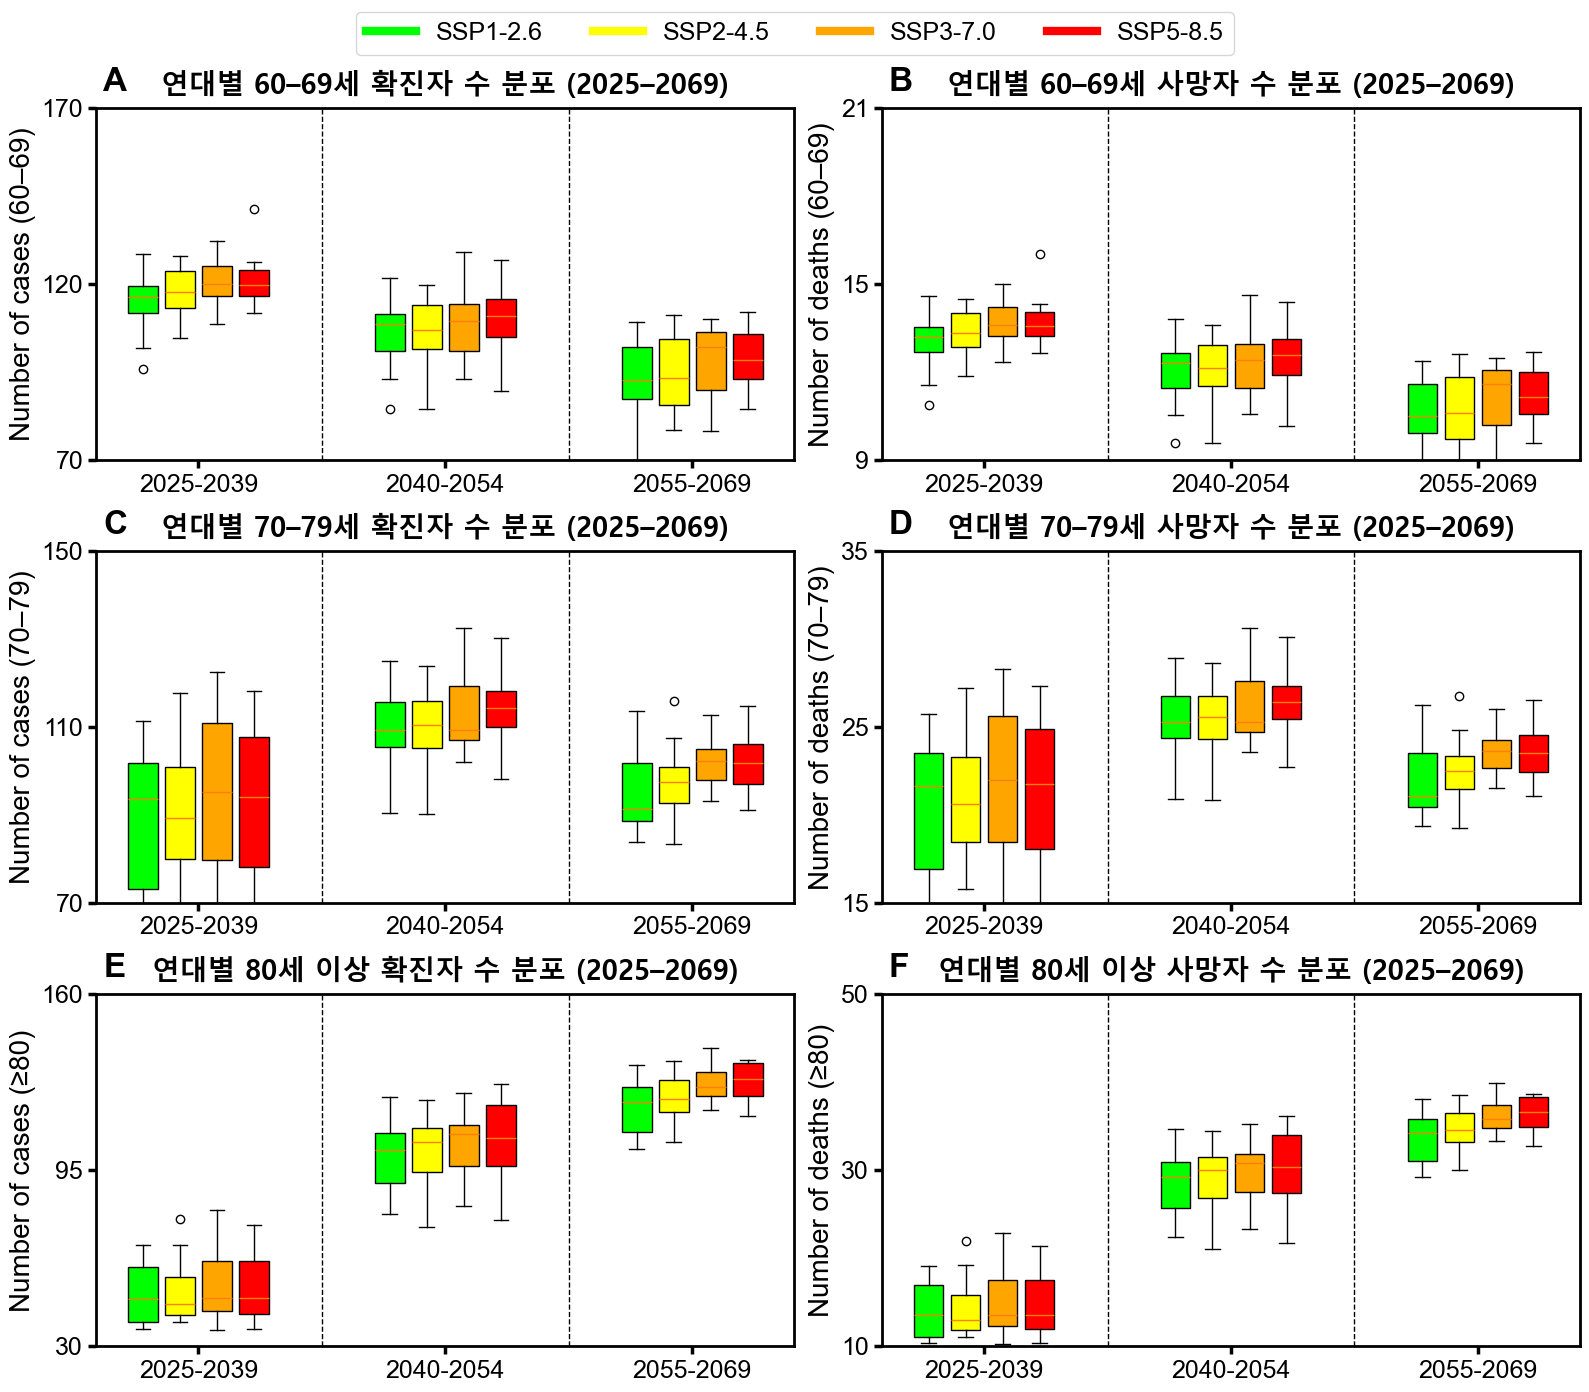

In [135]:
# 🔹 폰트 및 스타일 설정
rcParams['font.family'] = 'Arial'
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.linewidth'] = 2

# 🔹 파일 경로 (SSP만)

# 🔹 데이터 로드
ssp_case_dfs = [globals()['{}_case'.format(f)] for f in SSP_name]
ssp_death_dfs = [globals()['death_df_{}'.format(f)] for f in SSP_name]

# 🔹 시나리오명 및 색상
ssp_scenarios = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
colors = ['#00FF00', '#FFFF00', '#FFA500', '#FF0000']
width, gap = 1.5, 10

# 🔹 연대 라벨
internal_decades = ['2025~2039', '2040~2054', '2055~2069']
decades_labels = ['2025-2039', '2040-2054', '2055-2069']

# 🔹 데이터 생성 함수
def prepare_data(df, year_col, case_col):
    df['Decade'] = pd.cut(df[year_col], bins=[2024, 2039, 2054, 2069], labels=internal_decades)
    return df.groupby('Decade')[case_col].apply(list).to_dict()

# 🔹 확진자 및 사망자 데이터 저장용 딕셔너리
case_data_all = [{d: [] for d in internal_decades} for _ in range(3)]
death_data_all = [{d: [] for d in internal_decades} for _ in range(3)]

# 🔹 확진자 데이터 처리
for i, col_suffix in enumerate(['Cases_60_70', 'Cases_70_80', 'Cases_80']):
    for df, scen in zip(ssp_case_dfs, ssp_scenarios):
        col = f'{scen} {col_suffix}'
        data = prepare_data(df, 'Year', col)
        for dec in internal_decades:
            case_data_all[i][dec].append(data.get(dec, []))

# 🔹 사망자 데이터 처리
for i, col_suffix in enumerate(['Deaths_60_70', 'Deaths_70_80', 'Deaths_80']):
    for df, scen in zip(ssp_death_dfs, ssp_scenarios):
        col = f'{scen} {col_suffix}'
        data = prepare_data(df, 'Year', col)
        for dec in internal_decades:
            death_data_all[i][dec].append(data.get(dec, []))

# 🔹 Y축 설정
y_axis_settings = [
    (70, 170, 50, 'Number of cases (60–69)'),
    (9, 21, 6, 'Number of deaths (60–69)'),
    (70, 150, 40, 'Number of cases (70–79)'),
    (15, 35, 10, 'Number of deaths (70–79)'),
    (30, 160, 65, 'Number of cases (≥80)'),
    (10, 50, 20, 'Number of deaths (≥80)')
]
subplot_titles = [
    '연대별 60–69세 확진자 수 분포 (2025–2069)',
    '연대별 60–69세 사망자 수 분포 (2025–2069)',
    '연대별 70–79세 확진자 수 분포 (2025–2069)',
    '연대별 70–79세 사망자 수 분포 (2025–2069)',
    '연대별 80세 이상 확진자 수 분포 (2025–2069)',
    '연대별 80세 이상 사망자 수 분포 (2025–2069)'
]

# 🔹 Boxplot 시각화
fig, axs = plt.subplots(3, 2, figsize=(16, 14))
axs = axs.flatten()
labels_A_F = ['A', 'B', 'C', 'D', 'E', 'F']

for i, ax in enumerate(axs):
    ax.set_facecolor('white')
    is_case = i % 2 == 0
    data_dict = case_data_all[i // 2] if is_case else death_data_all[i // 2]
    ymin, ymax, tick_interval, ylabel_text = y_axis_settings[i]
    positions, x_centers = [], []

    for j, (decade_key, label_decade) in enumerate(zip(internal_decades, decades_labels)):
        pos = [gap * j + k * width for k in range(len(data_dict[decade_key]))]
        x_center = gap * j + (len(data_dict[decade_key]) - 1) * width / 2
        x_centers.append(x_center)
        positions.extend(pos)

        box = ax.boxplot(data_dict[decade_key], positions=pos, widths=1.2, patch_artist=True)
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        if j < len(internal_decades) - 1:
            ax.axvline(x=x_center + gap / 2, color='black', linestyle='--', linewidth=1)

    ax.set_xticks(x_centers)
    ax.set_xticklabels(decades_labels, fontsize=16)
    ax.tick_params(axis='x', labelsize=18, bottom=True, length=6, width=2.5, color='black')
    ax.tick_params(axis='y', labelsize=18, width=2.5, length=6)
    ax.set_ylabel(ylabel_text, fontsize=20)
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(range(ymin, ymax + 1, tick_interval))
    ax.text(0.01, 1.05, labels_A_F[i], transform=ax.transAxes, weight='bold', size=24)
    ax.set_title(subplot_titles[i], fontdict={'fontsize': 20, 'fontweight': 'bold', 'fontfamily': 'Malgun Gothic'}, pad=10, loc='center')

# 🔹 범례
legend_labels = ssp_scenarios
legend_handles = [plt.Line2D([0], [0], color=color, lw=6) for color in colors]
legend = fig.legend(handles=legend_handles,
                    labels=legend_labels,
                    loc='upper center',
                    fontsize=18,
                    frameon=True,
                    ncol=4)
legend.get_frame().set_facecolor('white')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [136]:
# 관측값 리스트 (이미 정의된 변수 사용)
observed_deaths_boxplot_data = [
    grouped_deaths['60-69'].dropna().tolist(),
    grouped_deaths['70-79'].dropna().tolist(),
    grouped_deaths['80+'].dropna().tolist()
]

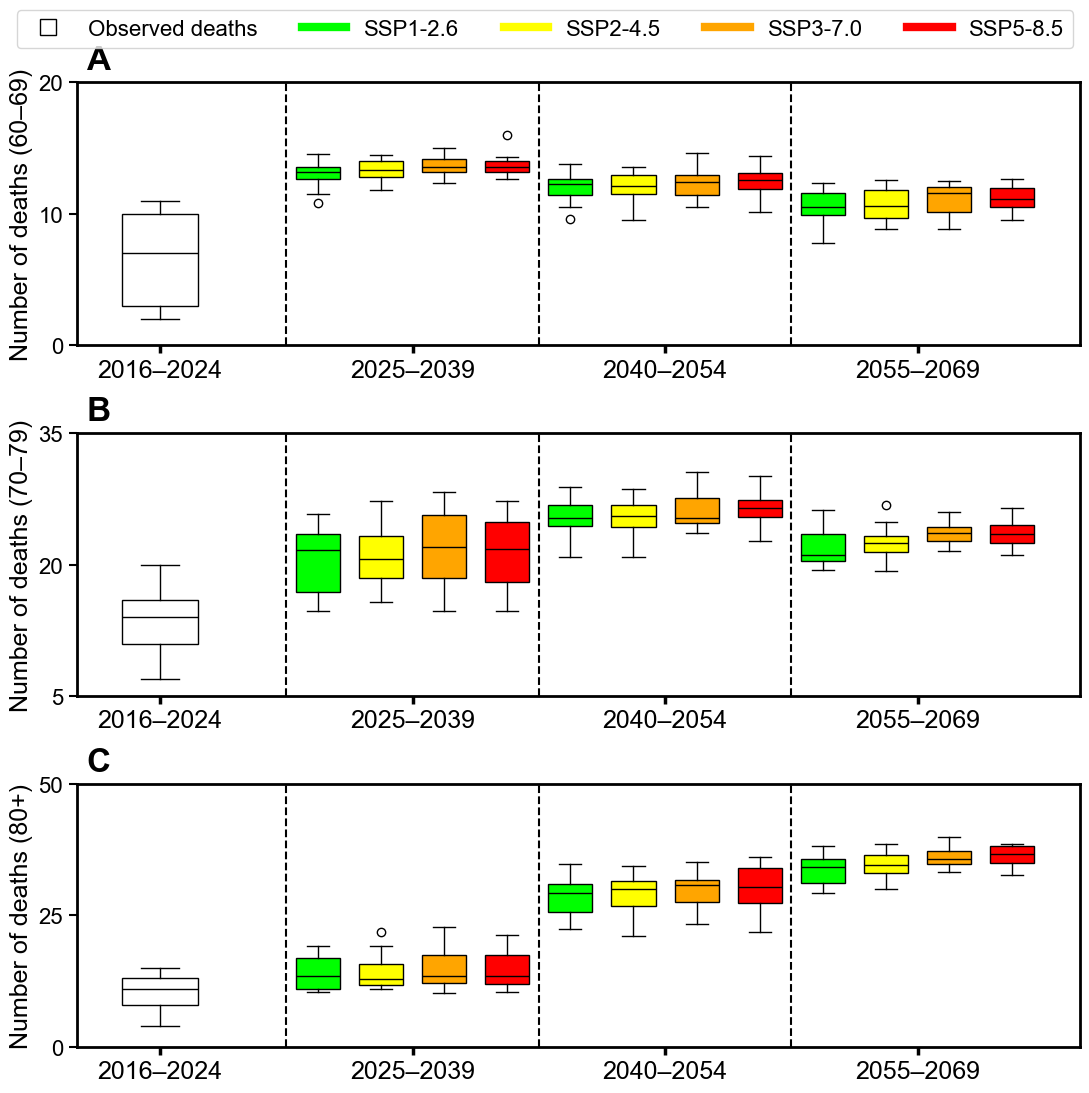

In [137]:
rcParams['font.family'] = 'Arial'

# 제목과 subplot 라벨에 사용할 한글 폰트 설정
title_font = {'fontsize': 20, 'fontname': 'Malgun Gothic', 'fontweight': 'bold'}
label_font = {'fontsize': 24, 'fontname': 'Arial', 'fontweight': 'bold'}

# 기본 설정
fig, axs = plt.subplots(3, 1, figsize=(11, 11))
axs = axs.flatten()

gap = 20
width = 5.0
obs_x = 5  # 관측값 위치

# 축 및 레이블 관련 설정
xticks_list = [[5, 25, 45, 65]] * 3
xtick_labels_list = [['2016–2024', '2025–2039', '2040–2054', '2055–2069']] * 3
yticks_list = [
    list(range(0, 21, 10)),
    list(range(5, 36, 15)),
    list(range(0, 51, 25))
]
ylims_list = [(0, 20), (5, 35), (0, 50)]
ylabels = [
    'Number of deaths (60–69)',
    'Number of deaths (70–79)',
    'Number of deaths (80+)'
]
labels = ['A', 'B', 'C']

# ✅ SSP만 사용
colors = ['#00FF00', '#FFFF00', '#FFA500', '#FF0000']
legend_labels = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
internal_decades = ['2025~2039', '2040~2054', '2055~2069']

# 🔁 반복 시각화
for i, ax in enumerate(axs):
    ax.set_facecolor('white')
    data_dict = death_data_all[i]
    x_centers = []

    # 관측값 박스플롯
    box_obs = ax.boxplot([observed_deaths_boxplot_data[i]],
                         positions=[obs_x],
                         widths=6.0,
                         patch_artist=True,
                         medianprops=dict(color='black'))
    for patch in box_obs['boxes']:
        patch.set_facecolor('white')
        patch.set_edgecolor('black')
    x_centers.append(obs_x)

    # SSP 시나리오 박스플롯
    for j, decade_key in enumerate(internal_decades):
        data = data_dict.get(decade_key, [])
        if not data or len(data) != len(colors):
            continue

        center = xticks_list[i][j + 1]
        pos = [center - (len(data) - 1) * width / 2 + k * width for k in range(len(data))]

        box = ax.boxplot(data, positions=pos, widths=3.5,
                         patch_artist=True, medianprops=dict(color='black'))
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')

        x_centers.append(sum(pos) / len(pos))

    # 구분선
    for j in range(len(x_centers) - 1):
        ax.axvline(x=(x_centers[j] + x_centers[j + 1]) / 2, color='black', linestyle='--')

    ax.set_xticks(xticks_list[i])
    ax.set_xticklabels(xtick_labels_list[i], fontsize=16)
    ax.set_yticks(yticks_list[i])
    ax.set_ylim(ylims_list[i])
    ax.set_ylabel(ylabels[i], fontsize=18)
    ax.tick_params(axis='x', labelsize=18, bottom=True, length=6, width=2.5, color='black')
    ax.tick_params(axis='y', left=True, length=5, width=2, color='black')
    ax.tick_params(axis='y', labelsize=16, width=1.5, length=6)
    ax.text(0.01, 1.05, labels[i], transform=ax.transAxes, **label_font)

    # 🔸 제목 제거됨
    # ax.set_title(subplot_titles[i], pad=10, loc='center', **title_font)

# ✅ 범례
legend_handles = [plt.Line2D([0], [0], color='black', markerfacecolor='white', marker='s', lw=0, markersize=12)] + \
                 [plt.Line2D([0], [0], color=c, lw=6) for c in colors]
legend_labels_full = ['Observed deaths'] + legend_labels

fig.legend(handles=legend_handles,
           labels=legend_labels_full,
           loc='upper center',
           fontsize=16,
           facecolor='white',
           frameon=True,
           ncol=5)

plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.savefig("C:\\Users\\user\\Dropbox\\CNN_LSTM\\Submission\\Figure\\Figure_5.png", dpi=350)  # 🔹 고해상도 저장
plt.show()

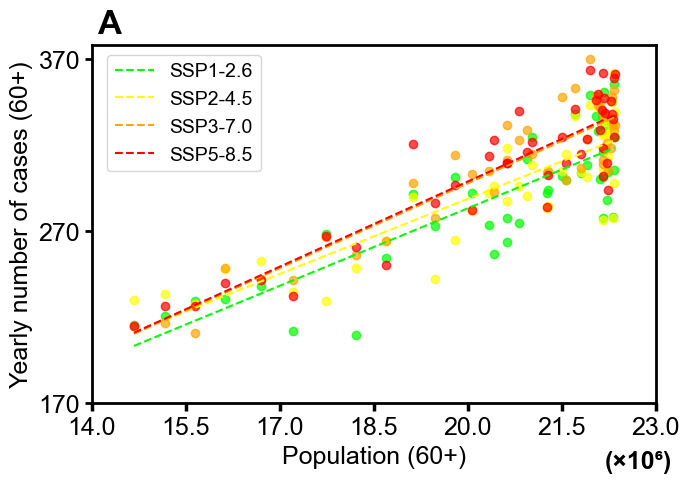

In [154]:
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as mticker

# 사용자 설정
xlabel1 = 'Population (60+)'
ylabel = 'Yearly number of cases (60+)'
legend_fontsize = 14
tick_fontsize = 18
label_fontsize = 18

title_fontsize = 18
x_ticks1 = np.arange(14000000, 23000001, 1500000)
y_ticks = np.arange(170, 371, 100)

rcParams['font.family'] = 'Arial'

# 파일 경로
for i in SSP_name:
    globals()['{}_df'.format(i)] = globals()['{}_reg'.format(i)]
    globals()['{}_df'.format(i)]['Population_60']=pop_df.loc[12:57,'population_60+'].values

ssp_dfs = {
    'SSP1-2.6': ssp126_df,
    'SSP2-4.5': ssp245_df,
    'SSP3-7.0': ssp370_df,
    'SSP5-8.5': ssp585_df
}

colors = {
    'SSP1-2.6': '#00FF00',
    'SSP2-4.5': '#FFFF00',
    'SSP3-7.0': '#FFA500',
    'SSP5-8.5': '#FF0000'
}

# 시각화 (인구수 기준 1개 그래프만)
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')

# A: Population_60 기준
for label, df in ssp_dfs.items():
    df = df[(df['Year'] >= 2025) & (df['Year'] <= 2069)]
    x = df['Population_60']
    y = df['Cases']
    model = LinearRegression().fit(x.values.reshape(-1, 1), y)
    x_line = np.linspace(min(x), max(x), 100)
    ax.scatter(x, y, color=colors[label], alpha=0.7)
    ax.plot(x_line, model.predict(x_line.reshape(-1, 1)), '--', color=colors[label], label=label)

# x축: 단위 조정
ax.ticklabel_format(style='plain', axis='x')
ax.xaxis.get_offset_text().set_visible(False)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}'))

# 축 설정 및 라벨
ax.set_xticks(x_ticks1)
ax.set_yticks(y_ticks)
ax.set_xlabel(xlabel1, fontsize=label_fontsize)
ax.set_ylabel(ylabel, fontsize=label_fontsize)
ax.tick_params(axis='both', labelsize=tick_fontsize)
ax.tick_params(axis='x', labelsize=18, bottom=True, length=6, width=2.5, color='black')
ax.tick_params(axis='y', left=True, length=5, width=2, color='black')
ax.grid(False)
ax.set_facecolor('white')
ax.text(0.01, 1.1, 'A', transform=ax.transAxes, weight='bold', size=24, va='top', ha='left')
ax.text(0.97, -0.13, '(×10⁶)', transform=ax.transAxes, weight='bold', fontsize=18, ha='center', va='top')

# 범례
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 1), fontsize=14, facecolor='white')

plt.tight_layout()
# plt.savefig("C:\\Users\\user\\Dropbox\\CNN_LSTM\\Submission\\Figure\\Figure_6.png", dpi=1050)  # 🔹 고해상도 저장
plt.show()

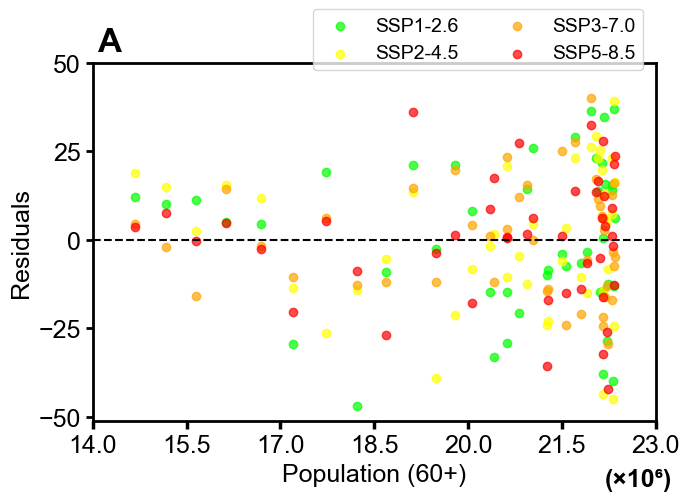

In [155]:
# 사용자 설정
xlabel1 = 'Population (60+)'
ylabel = 'Residuals'
legend_fontsize = 14
tick_fontsize = 18
label_fontsize = 18
title_fontsize = 18
x_ticks1 = np.arange(14000000, 23000001, 1500000)
y_ticks = np.arange(-50, 51, 25)  # 잔차 y축 눈금 범위

rcParams['font.family'] = 'Arial'


ssp_dfs = {
    'SSP1-2.6': ssp126_df,
    'SSP2-4.5': ssp245_df,
    'SSP3-7.0': ssp370_df,
    'SSP5-8.5': ssp585_df
}

colors = {
    'SSP1-2.6': '#00FF00',
    'SSP2-4.5': '#FFFF00',
    'SSP3-7.0': '#FFA500',
    'SSP5-8.5': '#FF0000'
}

# 시각화: 잔차 플롯
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')

for label, df in ssp_dfs.items():
    df = df[(df['Year'] >= 2025) & (df['Year'] <= 2069)]
    x = df['Population_60'].values.reshape(-1, 1)
    y = df['Cases'].values
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    residuals = y - y_pred
    ax.scatter(x, residuals, color=colors[label], alpha=0.7, label=label)

# X축 단위 설정
ax.ticklabel_format(style='plain', axis='x')
ax.xaxis.get_offset_text().set_visible(False)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}'))

# 축 설정
ax.set_xticks(x_ticks1)
ax.set_yticks(y_ticks)
ax.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax.set_xlabel(xlabel1, fontsize=label_fontsize)
ax.set_ylabel(ylabel, fontsize=label_fontsize)
ax.tick_params(axis='both', labelsize=tick_fontsize)
ax.tick_params(axis='x', bottom=True, length=6, width=2.5, color='black')
ax.tick_params(axis='y', left=True, length=5, width=2, color='black')
ax.set_facecolor('white')
ax.grid(False)

# 텍스트 및 단위 표시
ax.text(0.01, 1.1, 'A', transform=ax.transAxes, weight='bold', size=24, va='top', ha='left')
ax.text(0.97, -0.13, '(×10⁶)', transform=ax.transAxes, weight='bold', fontsize=18, ha='center', va='top')

# 범례
fig.legend(
    loc='upper center',
    ncol=2,
    fontsize=14,
    frameon=True,
    facecolor='white',
    bbox_to_anchor=(0.69, 1.02)
)

plt.tight_layout()
plt.show()

In [157]:
import pandas as pd
import statsmodels.api as sm

# 파일 경로
ssp_files = {
    'SSP126': 'SSP126_predictions_60_ver17_1_1.xlsx',
    'SSP245': 'SSP245_predictions_60_ver17_1_1.xlsx',
    'SSP370': 'SSP370_predictions_60_ver17_1_1.xlsx',
    'SSP585': 'SSP585_predictions_60_ver17_1_1.xlsx',
}

results = []

# 시나리오별 회귀 분석
num=0
for label, file in ssp_files.items():
    df = globals()['{}_df'.format(SSP_name[num])]

    # ✅ 연도 필터링 (2025~2070년)
    df = df[(df['Year'] >= 2025) & (df['Year'] <= 2069)]

    # 회귀 입력 변수
    x = df['Population_60']
    y = df['Cases']
    X = sm.add_constant(x)

    # 회귀 모델 적합
    model = sm.OLS(y, X).fit()

    # 회귀 계수 및 통계량
    alpha = model.params['const']
    beta = model.params['Population_60']

    std_alpha = model.bse['const']
    std_beta = model.bse['Population_60']

    t_slope = model.tvalues['Population_60']
    p_slope = model.pvalues['Population_60']

    t_intercept = model.tvalues['const']
    p_intercept = model.pvalues['const']

    ci_low, ci_high = model.conf_int().loc['Population_60']
    r2 = model.rsquared

    # 회귀식 문자열
    equation = f"Cases = {alpha:.2f} + {beta:.2e} × Population_60"

    # 결과 저장
    results.append({
        'Scenario': label,
        'R²': round(r2, 2),
        'α (intercept)': round(alpha, 2),
        'SE (α)': round(std_alpha, 2),
        't (α)': round(t_intercept, 2),
        'p (α)': f"{p_intercept:.1e}",
        'β (slope)': round(beta, 10),
        'SE (β)': round(std_beta, 10),
        '95% CI (β)': f"[{round(ci_low, 2)}, {round(ci_high, 2)}]",
        't (β)': round(t_slope, 2),
        'p (β)': f"{p_slope:.1e}",
        'Equation': equation
    })
    num=num+1

# 결과 DataFrame 생성 및 출력
results_df = pd.DataFrame(results)
pd.set_option('display.max_columns', None)
results_df


,Scenario,R²,α (intercept),SE (α),t (α),p (α),β (slope),SE (β),95% CI (β),t (β),p (β),Equation
0,SSP126,0.70,-16.71,30.79,-0.54,5.9e-01,0.000015,0.000001,"[0.0, 0.0]",10.06,7.2e-13,Cases = -16.71 + 1.50e-05 × Population_60
1,SSP245,0.72,-2.00,28.77,-0.07,9.5e-01,0.000015,0.000001,"[0.0, 0.0]",10.44,2.3e-13,Cases = -2.00 + 1.45e-05 × Population_60
2,SSP370,0.84,-30.24,22.71,-1.33,1.9e-01,0.000016,0.000001,"[0.0, 0.0]",14.92,1.3e-18,Cases = -30.24 + 1.64e-05 × Population_60
3,SSP585,0.81,-30.78,25.53,-1.21,2.3e-01,0.000016,0.000001,"[0.0, 0.0]",13.33,7.1e-17,Cases = -30.78 + 1.65e-05 × Population_60


In [158]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# 파일 경로
ssp_files = {
    'SSP126': 'SSP126_predictions_60_ver17_1_1.xlsx',
    'SSP245': 'SSP245_predictions_60_ver17_1_1.xlsx',
    'SSP370': 'SSP370_predictions_60_ver17_1_1.xlsx',
    'SSP585': 'SSP585_predictions_60_ver17_1_1.xlsx',
}

results = []
num=0
# 시나리오별 회귀 분석
for label, file in ssp_files.items():
    df = globals()['{}_df'.format(SSP_name[num])]
    # ✅ 연도 필터링 (2025~2070년)
    df = df[(df['Year'] >= 2025) & (df['Year'] <= 2069)]
    x = df['Population_60']
    y = df['Cases']
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    alpha = model.params['const']
    b = model.params['Population_60']
    t = model.tvalues['Population_60']
    p = model.pvalues['Population_60']
    ci_low, ci_high = model.conf_int().loc['Population_60']
    r2 = model.rsquared

    # β 계산 (표준화 계수)
    beta = (b * x.std()) / y.std()
    equation = f"Cases = {alpha:.2f} + {b:.2e} × Population_60"

    # 잔차 계산
    residuals = model.resid

    # 🔹 정규성 검정 (Shapiro-Wilk)
    _, shapiro_p = shapiro(residuals)

    # 🔹 등분산성 검정 (Breusch-Pagan)
    bp_test = het_breuschpagan(residuals, model.model.exog)
    bp_p = bp_test[1]

    # 🔹 독립성 검정 (Durbin-Watson)
    dw_stat = durbin_watson(residuals)

    results.append({
        'Scenario': label,
        'R²': round(r2, 2),
        'B': round(b, 2),
        'β': round(beta, 2),
        '95% CI': f"[{round(ci_low, 2)}, {round(ci_high, 2)}]",
        't': round(t, 2),
        'p-value': f"{p:.1e}",
        'DW (독립성)': round(dw_stat, 2),
        'BP p-value (등분산성)': f"{bp_p:.4f}",
        'Shapiro p-value (정규성)': f"{shapiro_p:.4f}",
        'Equation': equation
    })
    num=num+1

results_df = pd.DataFrame(results)
print(results_df)

  Scenario    R²    B     β      95% CI      t  p-value  DW (독립성)  \
0   SSP126  0.70  0.0  0.84  [0.0, 0.0]  10.06  7.2e-13      2.23   
1   SSP245  0.72  0.0  0.85  [0.0, 0.0]  10.44  2.3e-13      2.12   
2   SSP370  0.84  0.0  0.92  [0.0, 0.0]  14.92  1.3e-18      1.80   
3   SSP585  0.81  0.0  0.90  [0.0, 0.0]  13.33  7.1e-17      2.16   

  BP p-value (등분산성) Shapiro p-value (정규성)  \
0            0.3712                0.4384   
1            0.1750                0.4637   
2            0.0772                0.6547   
3            0.1365                0.7872   

                                    Equation  
0  Cases = -16.71 + 1.50e-05 × Population_60  
1   Cases = -2.00 + 1.45e-05 × Population_60  
2  Cases = -30.24 + 1.64e-05 × Population_60  
3  Cases = -30.78 + 1.65e-05 × Population_60  


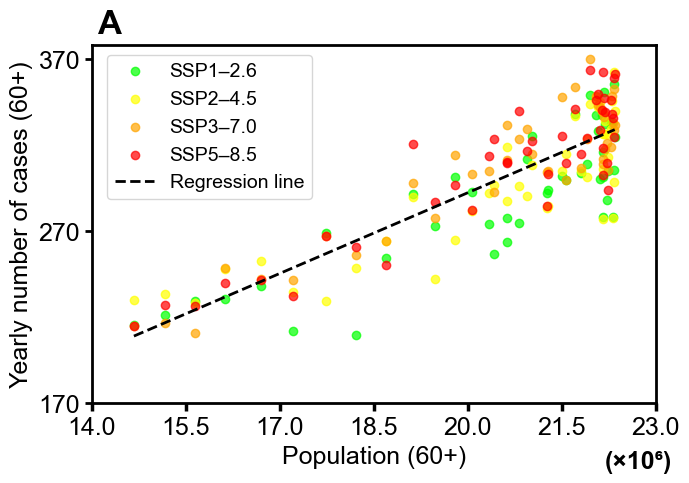

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import rcParams
import matplotlib.ticker as mticker

# 사용자 설정
xlabel1 = 'Population (60+)'
ylabel = 'Yearly number of cases (60+)'
legend_fontsize = 14
tick_fontsize = 18
label_fontsize = 18
title_fontsize = 18
x_ticks1 = np.arange(14000000, 23000001, 1500000)
y_ticks = np.arange(170, 371, 100)

rcParams['font.family'] = 'Arial'

# 파일 경로
file_paths = {
    'SSP1-2.6': 'SSP126_predictions_60_ver17_1_1.xlsx',
    'SSP2-4.5': 'SSP245_predictions_60_ver17_1_1.xlsx',
    'SSP3-7.0': 'SSP370_predictions_60_ver17_1_1.xlsx',
    'SSP5-8.5': 'SSP585_predictions_60_ver17_1_1.xlsx',
}

# 색상 설정
colors = {
    'SSP1-2.6': '#00FF00',
    'SSP2-4.5': '#FFFF00',
    'SSP3-7.0': '#FFA500',
    'SSP5-8.5': '#FF0000'
}

# ✅ 범례 이름 설정
labels = {
    'SSP1-2.6': 'SSP1–2.6',
    'SSP2-4.5': 'SSP2–4.5',
    'SSP3-7.0': 'SSP3–7.0',
    'SSP5-8.5': 'SSP5–8.5',
    'Regression line': 'Regression line'
}

# 시각화 (전체 데이터 통합 후 단일 회귀선)
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')

all_x = []
all_y = []

num=0
for label, path in file_paths.items():
    df = globals()['{}_df'.format(SSP_name[num])]
    df = df[(df['Year'] >= 2025) & (df['Year'] <= 2069)]
    x = df['Population_60']
    y = df['Cases']
    
    ax.scatter(x, y, color=colors[label], alpha=0.7, label=labels[label])
    
    all_x.append(x)
    all_y.append(y)
    num=num+1

# 회귀선 (전체)
x_all = pd.concat(all_x)
y_all = pd.concat(all_y)
model = LinearRegression().fit(x_all.values.reshape(-1, 1), y_all)
x_line = np.linspace(min(x_all), max(x_all), 100)
ax.plot(x_line, model.predict(x_line.reshape(-1, 1)), 'k--', linewidth=2, label=labels['Regression line'])

# x축 단위 조정
ax.ticklabel_format(style='plain', axis='x')
ax.xaxis.get_offset_text().set_visible(False)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}'))

# 축 설정
ax.set_xticks(x_ticks1)
ax.set_yticks(y_ticks)
ax.set_xlabel(xlabel1, fontsize=label_fontsize)
ax.set_ylabel(ylabel, fontsize=label_fontsize)
ax.tick_params(axis='both', labelsize=tick_fontsize)
ax.tick_params(axis='x', bottom=True, length=6, width=2.5, color='black')
ax.tick_params(axis='y', left=True, length=5, width=2, color='black')
ax.grid(False)
ax.set_facecolor('white')
ax.text(0.01, 1.1, 'A', transform=ax.transAxes, weight='bold', size=24, va='top', ha='left')
ax.text(0.97, -0.13, '(×10⁶)', transform=ax.transAxes, weight='bold', fontsize=18, ha='center', va='top')

# 범례 표시
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 1), fontsize=legend_fontsize, facecolor='white')

plt.tight_layout()
plt.show()

In [160]:
import pandas as pd
import statsmodels.api as sm

# 파일 경로
ssp_files = {
    'SSP126': 'SSP126_predictions_60_ver17_1_1.xlsx',
    'SSP245': 'SSP245_predictions_60_ver17_1_1.xlsx',
    'SSP370': 'SSP370_predictions_60_ver17_1_1.xlsx',
    'SSP585': 'SSP585_predictions_60_ver17_1_1.xlsx',
}

# 전체 데이터 통합
all_data = []
num=0
for file in ssp_files.values():
    df = globals()['{}_df'.format(SSP_name[num])]
    df = df[(df['Year'] >= 2025) & (df['Year'] <= 2069)]
    all_data.append(df[['Population_60', 'Cases']])
    num=num+1

combined_df = pd.concat(all_data, ignore_index=True)

# 회귀 입력 변수
x = combined_df['Population_60']
y = combined_df['Cases']
X = sm.add_constant(x)

# 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 계수 및 통계량
alpha = model.params['const']
beta = model.params['Population_60']

std_alpha = model.bse['const']
std_beta = model.bse['Population_60']

t_slope = model.tvalues['Population_60']
p_slope = model.pvalues['Population_60']

t_intercept = model.tvalues['const']
p_intercept = model.pvalues['const']

ci_low, ci_high = model.conf_int().loc['Population_60']
r2 = model.rsquared

# 회귀식 문자열
equation = f"Cases = {alpha:.2f} + {beta:.2e} × Population_60"

# 결과 저장
results_df = pd.DataFrame([{
    'Scenario': 'Combined SSPs',
    'R²': round(r2, 2),
    'α (intercept)': round(alpha, 2),
    'SE (α)': round(std_alpha, 2),
    't (α)': round(t_intercept, 2),
    'p (α)': f"{p_intercept:.1e}",
    'β (slope)': round(beta, 10),
    'SE (β)': round(std_beta, 10),
    '95% CI (β)': f"[{round(ci_low, 2)}, {round(ci_high, 2)}]",
    't (β)': round(t_slope, 2),
    'p (β)': f"{p_slope:.1e}",
    'Equation': equation
}])

# 결과 출력
pd.set_option('display.max_columns', None)
results_df


,Scenario,R²,α (intercept),SE (α),t (α),p (α),β (slope),SE (β),95% CI (β),t (β),p (β),Equation
0,Combined SSPs,0.74,-19.93,14.26,-1.4,1.6e-01,0.000016,6.908000e-07,"[0.0, 0.0]",22.6,3.5e-54,Cases = -19.93 + 1.56e-05 × Population_60


In [161]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# 🔹 시나리오별 파일 경로
ssp_files = {
    'SSP126': 'SSP126_predictions_60_ver17_1_1.xlsx',
    'SSP245': 'SSP245_predictions_60_ver17_1_1.xlsx',
    'SSP370': 'SSP370_predictions_60_ver17_1_1.xlsx',
    'SSP585': 'SSP585_predictions_60_ver17_1_1.xlsx',
}

# 🔹 전체 데이터 통합
all_data = []
num=0
for file in ssp_files.values():
    df = globals()['{}_df'.format(SSP_name[num])]
    df = df[(df['Year'] >= 2025) & (df['Year'] <= 2069)]
    all_data.append(df[['Population_60', 'Cases']])
    num=num+1

combined_df = pd.concat(all_data, ignore_index=True)

# 🔹 회귀 분석
x = combined_df['Population_60']
y = combined_df['Cases']
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

# 🔹 회귀 계수 및 통계량
alpha = model.params['const']
b = model.params['Population_60']
t = model.tvalues['Population_60']
p = model.pvalues['Population_60']
ci_low, ci_high = model.conf_int().loc['Population_60']
r2 = model.rsquared
beta = (b * x.std()) / y.std()
equation = f"Cases = {alpha:.2f} + {b:.2e} × Population_60"

# 🔹 잔차 분석
residuals = model.resid
shapiro_p = shapiro(residuals)[1]
bp_p = het_breuschpagan(residuals, model.model.exog)[1]
dw_stat = durbin_watson(residuals)

# 🔹 결과 저장
results = pd.DataFrame([{
    'DW (독립성)': round(dw_stat, 2),
    'BP p-value (등분산성)': f"{bp_p:.4f}",
    'Shapiro p-value (정규성)': f"{shapiro_p:.4f}",
}])

# 🔹 결과 출력
pd.set_option('display.max_columns', None)
results


,DW (독립성),BP p-value (등분산성),Shapiro p-value (정규성)
0,1.9,0.0256,0.1132


In [163]:
ssp126_case

,Year,Cases,Decade,Period,SSP1-2.6 Cases_60_70,SSP1-2.6 Cases_70_80,SSP1-2.6 Cases_80,SSP1-2.6 Deaths_60_70,SSP1-2.6 Deaths_70_80,SSP1-2.6 Deaths_80
0,2025,215.397196,2025~2039,2025–2039,115.178127,63.838103,36.380967,13.061200,14.752986,10.361299
1,2026,221.045797,2025~2039,2025–2039,116.297997,67.990534,36.757266,13.188193,15.712612,10.468469
2,2027,229.275034,2025~2039,2025–2039,118.255442,71.924842,39.094751,13.410167,16.621831,11.134185
3,2028,230.420056,2025~2039,2025–2039,116.262548,74.048408,40.109100,13.184173,17.112587,11.423072
4,2029,238.260294,2025~2039,2025–2039,117.920740,78.431360,41.908195,13.372212,18.125487,11.935454
5,2030,212.034119,2025~2039,2025–2039,101.821190,72.335591,37.877338,11.546523,16.716755,10.787466
6,2031,268.665705,2025~2039,2025–2039,124.958764,95.822845,47.884095,14.170324,22.144660,13.637390
7,2032,209.729351,2025~2039,2025–2039,95.815281,75.634396,38.279674,10.865453,17.479109,10.902051
8,2033,254.618055,2025~2039,2025–2039,113.478965,93.688719,47.450372,12.868515,21.651463,13.513866
9,2034,291.495266,2025~2039,2025–2039,128.535942,107.445425,55.513900,14.575976,24.830638,15.810359


C:\Users\yogof\AppData\Local\Temp\ipykernel_35180\3006243268.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('Decade')[cases_column].apply(list).to_dict()
C:\Users\yogof\AppData\Local\Temp\ipykernel_35180\3006243268.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('Decade')[cases_column].apply(list).to_dict()
C:\Users\yogof\AppData\Local\Temp\ipykernel_35180\3006243268.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt t

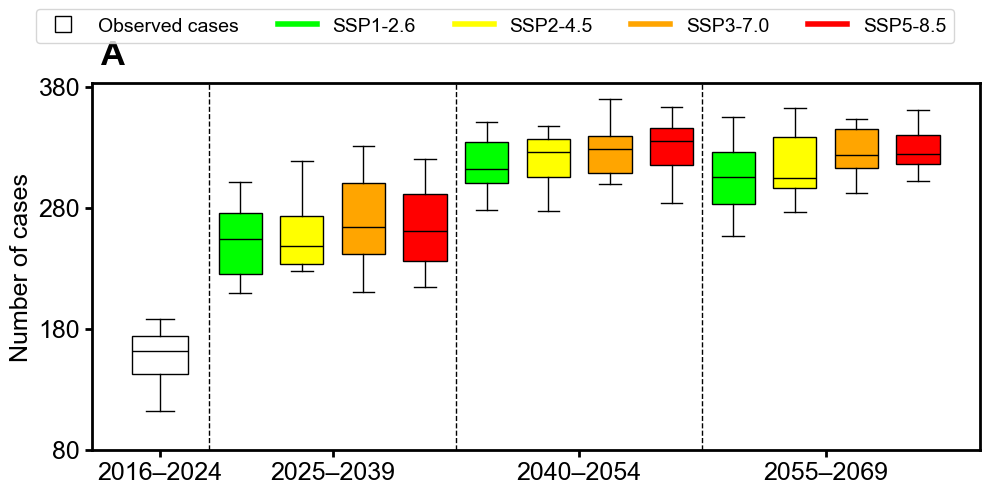

In [164]:
# 🔹 폰트 설정
rcParams['font.family'] = 'Arial'

# 🔹 관측값 데이터 로드
obs_df = pd.read_excel('./Data/New_data11.xlsx')
obs_filtered = obs_df[(obs_df['Year'] >= 2016) & (obs_df['Year'] <= 2024)]
obs_grouped = obs_filtered.groupby('Year')['Cases_60'].sum()
observed_cases = obs_grouped.tolist()

# 🔹 시나리오 데이터 로드 및 정리
def prepare_decade_data(df, year_column, cases_column):
    df['Decade'] = pd.cut(df[year_column], bins=[2024, 2039, 2054, 2069],
                          labels=['2025~2039', '2040~2054', '2055~2069'])
    return df.groupby('Decade')[cases_column].apply(list).to_dict()

for i in SSP_name:
    globals()['{}_df'.format(i)] = globals()['{}_reg'.format(i)]

ssp126_decades = prepare_decade_data(ssp126_df, 'Year', 'Cases')
ssp245_decades = prepare_decade_data(ssp245_df, 'Year', 'Cases')
ssp370_decades = prepare_decade_data(ssp370_df, 'Year', 'Cases')
ssp585_decades = prepare_decade_data(ssp585_df, 'Year', 'Cases')

# 🔹 박스플롯용 데이터 구성 (RCP 제거)
cases_data_by_decade_with_obs = {
    '2016~2023': [observed_cases],
    '2025~2039': [
        ssp126_decades.get('2025~2039', []), ssp245_decades.get('2025~2039', []),
        ssp370_decades.get('2025~2039', []), ssp585_decades.get('2025~2039', []),
    ],
    '2040~2054': [
        ssp126_decades.get('2040~2054', []), ssp245_decades.get('2040~2054', []),
        ssp370_decades.get('2040~2054', []), ssp585_decades.get('2040~2054', []),
    ],
    '2055~2069': [
        ssp126_decades.get('2055~2069', []), ssp245_decades.get('2055~2069', []),
        ssp370_decades.get('2055~2069', []), ssp585_decades.get('2055~2069', []),
    ]
}

# 🔹 색상 및 라벨 설정 (RCP 제거)
scenario_colors = ['#00FF00', '#FFFF00', '#FFA500', '#FF0000']
scenario_labels = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
all_labels = ['Observed cases'] + scenario_labels

# 🔹 시각화 시작
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x_centers = [10, 30, 50, 70]
width = 5.0
positions = []

ax.set_facecolor('white')

for i, (decade, data) in enumerate(cases_data_by_decade_with_obs.items()):
    n = len(data)
    center = x_centers[i]

    if i == 0:
        pos = [center + 6]  # 관측값 x 위치
        box = ax.boxplot(data, positions=pos, widths=4.5, patch_artist=True,
                         medianprops=dict(color='black'))
        for patch in box['boxes']:
            patch.set_facecolor('white')
            patch.set_edgecolor('black')
    else:
        offset = (n - 1) * width / 2
        pos = [center - offset + j * width for j in range(n)]
        box = ax.boxplot(data, positions=pos, widths=3.5, patch_artist=True,
                         medianprops=dict(color='black'))
        for j, patch in enumerate(box['boxes']):
            patch.set_facecolor(scenario_colors[j])
            patch.set_edgecolor('black')

    positions.extend(pos)

    if i < len(cases_data_by_decade_with_obs) - 1:
        ax.axvline(x=(x_centers[i] + x_centers[i + 1]) / 2,
                   color='black', linestyle='--', linewidth=1)

# 🔹 눈금 설정 및 라벨 직접 지정
ax.set_xticks([16, 30, 50, 70])
ax.set_xticklabels(['2016–2024', '2025–2039', '2040–2054', '2055–2069'], fontsize=18)
ax.tick_params(axis='x', bottom=True, length=5, width=2, color='black')
ax.tick_params(axis='y', left=True, length=5, width=2, color='black')
ax.set_ylim(80, 383)
ax.set_yticks(range(80, 383, 100))
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel('Number of cases', fontsize=18)

# 🔹 제목 및 레이블
ax.text(0.01, 1.05, "A", transform=ax.transAxes, weight='bold', size=24)


# 🔹 범례
legend = fig.legend(handles=[plt.Line2D([0], [0], color='black', marker='s', markerfacecolor='white', lw=0, markersize=12)] +
                             [plt.Line2D([0], [0], color=c, lw=4) for c in scenario_colors],
                    labels=all_labels,
                    loc='upper center',
                    fontsize=14,
                    ncol=5,
                    frameon=True)
legend.get_frame().set_facecolor('white')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [165]:
import scipy.stats as stats
import pandas as pd

# 🔹 SSP만 추출한 2025~2039 연대의 시나리오별 연간 확진자 수
anova_data_cases = [
    ssp126_decades['2025~2039'],
    ssp245_decades['2025~2039'],
    ssp370_decades['2025~2039'],
    ssp585_decades['2025~2039'],
]

# 🔹 ANOVA 검정 수행
f_statistic_cases, p_value_cases = stats.f_oneway(*anova_data_cases)

# 🔹 분산분석표 생성
grand_mean = sum(sum(group) for group in anova_data_cases) / sum(len(group) for group in anova_data_cases)

ss_between = round(sum(len(group) * (sum(group) / len(group) - grand_mean)**2 for group in anova_data_cases), 2)
df_between = len(anova_data_cases) - 1
ms_between = round(ss_between / df_between, 2)

ss_within = round(sum(sum((x - sum(group) / len(group))**2 for x in group) for group in anova_data_cases), 2)
df_within = sum(len(group) - 1 for group in anova_data_cases)
ms_within = round(ss_within / df_within, 2)

total_ss = round(ss_between + ss_within, 2)
total_df = df_between + df_within
total_ms = round(total_ss / total_df, 2)

anova_table = pd.DataFrame({
    '제곱합 (SS)': [ss_between, ss_within, total_ss],
    '자유도 (df)': [df_between, df_within, total_df],
    '제곱 평균 (MS)': [ms_between, ms_within, total_ms],
    'F 값': [f_statistic_cases, '', ''],
    'p-값': [p_value_cases, '', '']
}, index=['집단간', '집단내', '총합'])

# 🔹 결과 출력
print(anova_table.to_string())

     제곱합 (SS)  자유도 (df)  제곱 평균 (MS)       F 값       p-값
집단간   1809.53         3      603.18  0.540831  0.656316
집단내  62455.56        56     1115.28                    
총합   64265.09        59     1089.24                    


In [166]:
import scipy.stats as stats
import pandas as pd
import itertools

# 🔹 2025~2039 연대의 SSP 시나리오별 연간 확진자 수 데이터 추출
anova_data_cases = [
    ssp126_decades['2025~2039'],
    ssp245_decades['2025~2039'],
    ssp370_decades['2025~2039'],
    ssp585_decades['2025~2039'],
]
scenario_names = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']

# 🔹 가능한 모든 SSP 조합에 대해 t-test 수행
t_test_results = []
for (i, j) in itertools.combinations(range(len(scenario_names)), 2):
    group1 = scenario_names[i]
    group2 = scenario_names[j]
    t_stat, p_value = stats.ttest_ind(anova_data_cases[i], anova_data_cases[j], equal_var=False)
    t_test_results.append({
        '비교 그룹': f'{group1} vs {group2}',
        't-값': round(t_stat, 4),
        'p-값': round(p_value, 4)
    })

# 🔹 결과 출력
t_test_table = pd.DataFrame(t_test_results)
print("🔹 SSP 시나리오 간 T-검정 결과:")
print(t_test_table.to_string(index=False))

🔹 SSP 시나리오 간 T-검정 결과:
               비교 그룹     t-값    p-값
SSP1-2.6 vs SSP2-4.5 -0.4274 0.6724
SSP1-2.6 vs SSP3-7.0 -1.0450 0.3052
SSP1-2.6 vs SSP5-8.5 -0.9869 0.3322
SSP2-4.5 vs SSP3-7.0 -0.7232 0.4761
SSP2-4.5 vs SSP5-8.5 -0.6465 0.5235
SSP3-7.0 vs SSP5-8.5  0.1012 0.9201


In [167]:
# 🔹 p-값이 0.05보다 작은 경우만 필터링 및 출력
significant_results = t_test_table[t_test_table['p-값'] < 0.05]

print("\n🔹 유의미한 결과 (p < 0.05):")
print(significant_results.to_string(index=False))


🔹 유의미한 결과 (p < 0.05):
Empty DataFrame
Columns: [비교 그룹, t-값, p-값]
Index: []


In [168]:
import scipy.stats as stats
import pandas as pd

# 🔹 SSP만 추출한 2025~2039 연대의 시나리오별 연간 확진자 수
anova_data_cases = [
    ssp126_decades['2040~2054'],
    ssp245_decades['2040~2054'],
    ssp370_decades['2040~2054'],
    ssp585_decades['2040~2054'],
]

# 🔹 ANOVA 검정 수행
f_statistic_cases, p_value_cases = stats.f_oneway(*anova_data_cases)

# 🔹 분산분석표 생성
grand_mean = sum(sum(group) for group in anova_data_cases) / sum(len(group) for group in anova_data_cases)

ss_between = round(sum(len(group) * (sum(group) / len(group) - grand_mean)**2 for group in anova_data_cases), 2)
df_between = len(anova_data_cases) - 1
ms_between = round(ss_between / df_between, 2)

ss_within = round(sum(sum((x - sum(group) / len(group))**2 for x in group) for group in anova_data_cases), 2)
df_within = sum(len(group) - 1 for group in anova_data_cases)
ms_within = round(ss_within / df_within, 2)

total_ss = round(ss_between + ss_within, 2)
total_df = df_between + df_within
total_ms = round(total_ss / total_df, 2)

anova_table = pd.DataFrame({
    '제곱합 (SS)': [ss_between, ss_within, total_ss],
    '자유도 (df)': [df_between, df_within, total_df],
    '제곱 평균 (MS)': [ms_between, ms_within, total_ms],
    'F 값': [f_statistic_cases, '', ''],
    'p-값': [p_value_cases, '', '']
}, index=['집단간', '집단내', '총합'])

# 🔹 결과 출력
print(anova_table.to_string())


     제곱합 (SS)  자유도 (df)  제곱 평균 (MS)      F 값       p-값
집단간   1787.79         3      595.93  1.23382  0.306043
집단내  27047.76        56      483.00                   
총합   28835.55        59      488.74                   


In [169]:
import scipy.stats as stats
import pandas as pd
import itertools

# 🔹 2025~2039 연대의 SSP 시나리오별 연간 확진자 수 데이터 추출
anova_data_cases = [
    ssp126_decades['2040~2054'],
    ssp245_decades['2040~2054'],
    ssp370_decades['2040~2054'],
    ssp585_decades['2040~2054'],
]
scenario_names = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']

# 🔹 가능한 모든 SSP 조합에 대해 t-test 수행
t_test_results = []
for (i, j) in itertools.combinations(range(len(scenario_names)), 2):
    group1 = scenario_names[i]
    group2 = scenario_names[j]
    t_stat, p_value = stats.ttest_ind(anova_data_cases[i], anova_data_cases[j], equal_var=False)
    t_test_results.append({
        '비교 그룹': f'{group1} vs {group2}',
        't-값': round(t_stat, 4),
        'p-값': round(p_value, 4)
    })

# 🔹 결과 출력
t_test_table = pd.DataFrame(t_test_results)
print("🔹 SSP 시나리오 간 T-검정 결과:")
print(t_test_table.to_string(index=False))

🔹 SSP 시나리오 간 T-검정 결과:
               비교 그룹     t-값    p-값
SSP1-2.6 vs SSP2-4.5 -0.2935 0.7713
SSP1-2.6 vs SSP3-7.0 -1.3442 0.1898
SSP1-2.6 vs SSP5-8.5 -1.6079 0.1191
SSP2-4.5 vs SSP3-7.0 -1.0116 0.3205
SSP2-4.5 vs SSP5-8.5 -1.2965 0.2054
SSP3-7.0 vs SSP5-8.5 -0.3794 0.7073


In [170]:
# 🔹 p-값이 0.05보다 작은 경우만 필터링
significant_results = t_test_table[t_test_table['p-값'] < 0.05]

# 🔹 결과 출력
print(significant_results.to_string(index=False))

Empty DataFrame
Columns: [비교 그룹, t-값, p-값]
Index: []


In [171]:
import scipy.stats as stats
import pandas as pd

# 🔹 SSP만 추출한 2025~2039 연대의 시나리오별 연간 확진자 수
anova_data_cases = [
    ssp126_decades['2055~2069'],
    ssp245_decades['2055~2069'],
    ssp370_decades['2055~2069'],
    ssp585_decades['2055~2069'],
]

# 🔹 ANOVA 검정 수행
f_statistic_cases, p_value_cases = stats.f_oneway(*anova_data_cases)

# 🔹 분산분석표 생성
grand_mean = sum(sum(group) for group in anova_data_cases) / sum(len(group) for group in anova_data_cases)

ss_between = round(sum(len(group) * (sum(group) / len(group) - grand_mean)**2 for group in anova_data_cases), 2)
df_between = len(anova_data_cases) - 1
ms_between = round(ss_between / df_between, 2)

ss_within = round(sum(sum((x - sum(group) / len(group))**2 for x in group) for group in anova_data_cases), 2)
df_within = sum(len(group) - 1 for group in anova_data_cases)
ms_within = round(ss_within / df_within, 2)

total_ss = round(ss_between + ss_within, 2)
total_df = df_between + df_within
total_ms = round(total_ss / total_df, 2)

anova_table = pd.DataFrame({
    '제곱합 (SS)': [ss_between, ss_within, total_ss],
    '자유도 (df)': [df_between, df_within, total_df],
    '제곱 평균 (MS)': [ms_between, ms_within, total_ms],
    'F 값': [f_statistic_cases, '', ''],
    'p-값': [p_value_cases, '', '']
}, index=['집단간', '집단내', '총합'])

# 🔹 결과 출력
print(anova_table.to_string())


     제곱합 (SS)  자유도 (df)  제곱 평균 (MS)       F 값      p-값
집단간   5717.07         3     1905.69  3.402307  0.02378
집단내  31366.57        56      560.12                   
총합   37083.64        59      628.54                   


In [172]:
import scipy.stats as stats
import pandas as pd
import itertools

# 🔹 2025~2039 연대의 SSP 시나리오별 연간 확진자 수 데이터 추출
anova_data_cases = [
    ssp126_decades['2055~2069'],
    ssp245_decades['2055~2069'],
    ssp370_decades['2055~2069'],
    ssp585_decades['2055~2069'],
]
scenario_names = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']

# 🔹 가능한 모든 SSP 조합에 대해 t-test 수행
t_test_results = []
for (i, j) in itertools.combinations(range(len(scenario_names)), 2):
    group1 = scenario_names[i]
    group2 = scenario_names[j]
    t_stat, p_value = stats.ttest_ind(anova_data_cases[i], anova_data_cases[j], equal_var=False)
    t_test_results.append({
        '비교 그룹': f'{group1} vs {group2}',
        't-값': round(t_stat, 4),
        'p-값': round(p_value, 4)
    })

# 🔹 결과 출력
t_test_table = pd.DataFrame(t_test_results)
print("🔹 SSP 시나리오 간 T-검정 결과:")
print(t_test_table.to_string(index=False))

🔹 SSP 시나리오 간 T-검정 결과:
               비교 그룹     t-값    p-값
SSP1-2.6 vs SSP2-4.5 -0.8636 0.3953
SSP1-2.6 vs SSP3-7.0 -2.4527 0.0218
SSP1-2.6 vs SSP5-8.5 -2.6422 0.0143
SSP2-4.5 vs SSP3-7.0 -1.5983 0.1223
SSP2-4.5 vs SSP5-8.5 -1.8032 0.0832
SSP3-7.0 vs SSP5-8.5 -0.2478 0.8061


In [173]:
# 🔹 p-값이 0.05보다 작은 경우만 필터링
significant_results = t_test_table[t_test_table['p-값'] < 0.05]

# 🔹 결과 출력
print(significant_results.to_string(index=False))

               비교 그룹     t-값    p-값
SSP1-2.6 vs SSP3-7.0 -2.4527 0.0218
SSP1-2.6 vs SSP5-8.5 -2.6422 0.0143


In [175]:
DNN_pred_test

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0170e-01, 5.7409e-02,
        1.3460e-01, 1.8107e-01, 3.5918e-01, 1.8834e-01, 3.4852e-01, 3.7715e-01,
        3.9698e-01, 3.0764e-01, 2.9815e-01, 3.1210e-01, 3.2492e-01, 4.3546e-01,
        5.7650e-01, 4.1446e-01, 3.5979e-01, 4.3313e-01, 5.2780e-01, 5.0503e-01,
        5.6923e-01, 4.3226e-01, 4.8801e-01, 1.1334e+00, 1.1700e+00, 8.8634e-01,
        3.7909e-01, 1.6193e-01, 3.5509e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.0088e-03, 4.3111e-02, 1.0108e-01, 3.1600e-01, 1.7600e-01,
        3.4608e-01, 4.6735e-01, 4.2652e-

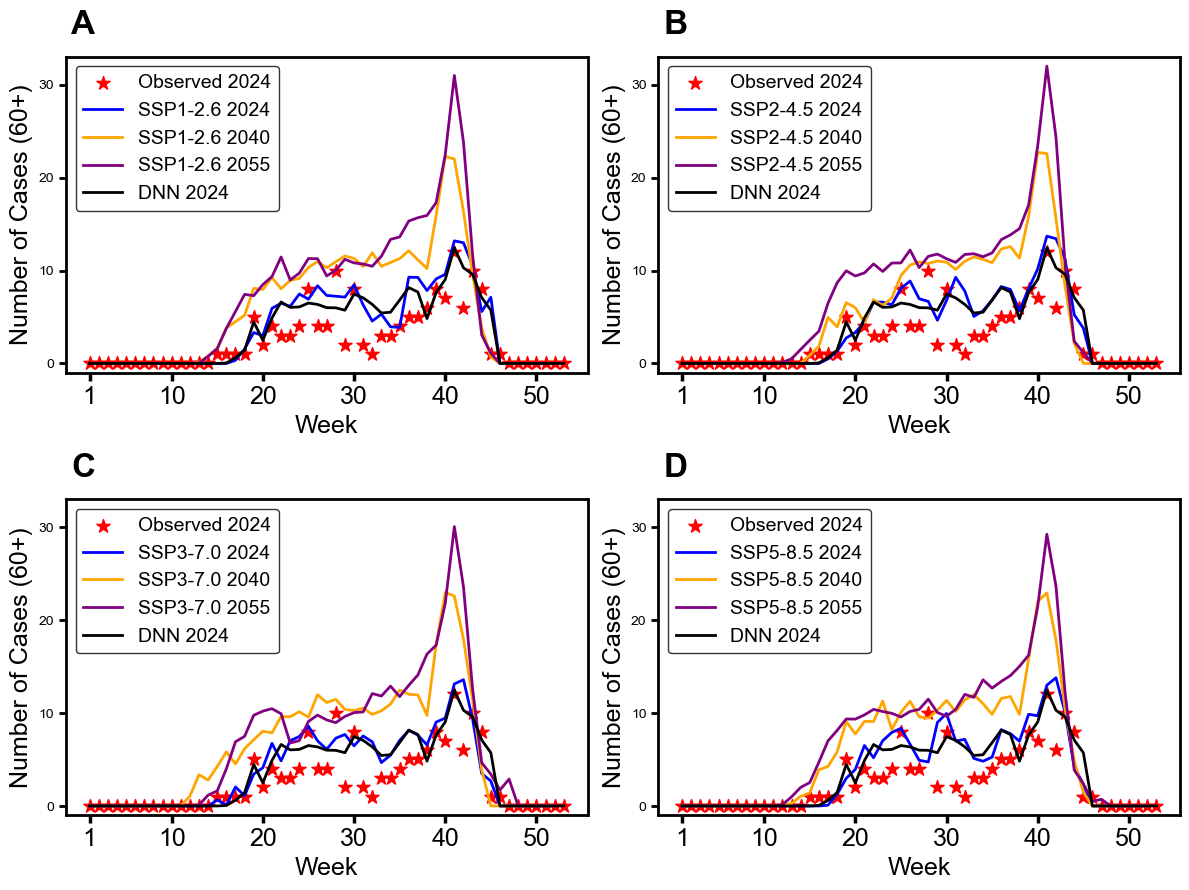

In [178]:
import pandas as pd
import matplotlib.pyplot as plt

# 🔹 Step 1: 연도 설정 및 파일 경로 정의
years_2024 = [2024]
years_future = [2040, 2055]

weekly_files_2024 = {
    "SSP126": "./Data/SSP126_predictions_weekly_cases_60_ver18_1.xlsx",
    "SSP245": "./Data/SSP245_predictions_weekly_cases_60_ver18_1.xlsx",
    "SSP370": "./Data/SSP370_predictions_weekly_cases_60_ver18_1.xlsx",
    "SSP585": "./Data/SSP585_predictions_weekly_cases_60_ver18_1.xlsx",
}
weekly_files_future = {
    "SSP126": "SSP126_predictions_weekly_cases_60_ver17_1.xlsx",
    "SSP245": "SSP245_predictions_weekly_cases_60_ver17_1.xlsx",
    "SSP370": "SSP370_predictions_weekly_cases_60_ver17_1.xlsx",
    "SSP585": "SSP585_predictions_weekly_cases_60_ver17_1.xlsx",
}


# 🔹 Step 2: 시나리오별 연도 필터링 후 저장
weekly_data_by_scenario = {}

for scenario in weekly_files_2024.keys():
    # 2024년 → ver18_1에서 불러오기
    df_2024 = pd.read_excel(weekly_files_2024[scenario])
    data_2024 = {
        "2024": df_2024[df_2024["Year"] == 2024][["Week", "Cases"]]
    }

    # 2040, 2055년 → ver17_1에서 불러오기
    df_future = globals()['df_{}'.format(scenario)]
    data_future = {
        str(year): df_future[df_future["Year"] == year][["Week", "Cases"]]
        for year in years_future
        if year in df_future["Year"].unique()
    }

    # 병합하여 저장
    weekly_data_by_scenario[scenario] = {**data_2024, **data_future}

# 🔹 Step 3: 관측값 및 DNN 예측값 로드
new_data = pd.read_excel("./Data/New_data11.xlsx")



new_data_2024 = new_data[new_data['Year'] == 2024][['Week', 'Cases_60']]
dnn_data_2024 = pred_all[pred_all['Year'] == 2024][['Week', 'DNN']]

# 🔹 Step 4: 시나리오/연도별 스타일 정의
scenario_labels = {
    "SSP126": "SSP1-2.6",
    "SSP245": "SSP2-4.5",
    "SSP370": "SSP3-7.0",
    "SSP585": "SSP5-8.5",
}
year_colors = {
    "2024": "blue",
    "2040": "orange",
    "2055": "purple",
}

# 🔹 Step 5: 그래프 생성
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.patch.set_facecolor('white')
scenario_order = {(0, 0): "SSP126", (0, 1): "SSP245", (1, 0): "SSP370", (1, 1): "SSP585"}
labels = ["A", "B", "C", "D"]

for idx, ((row, col), scenario_name) in enumerate(scenario_order.items()):
    ax = axes[row, col]
    scenario_yearly = weekly_data_by_scenario[scenario_name]
    ax.set_facecolor('white')

    # 관측값 (2024년)
    ax.scatter(new_data_2024['Week'], new_data_2024['Cases_60'], label='Observed 2024', marker='*', color='red', s=100)

    # 시나리오 예측값 (2024, 2040, 2055)
    for year in ["2024", "2040", "2055"]:
        if year in scenario_yearly:
            data = scenario_yearly[year]
            ax.plot(data['Week'], data['Cases'], label=f"{scenario_labels[scenario_name]} {year}", color=year_colors[year], linewidth=2)

    # DNN 예측값 (2024년)
    ax.plot(dnn_data_2024['Week'], dnn_data_2024['DNN'], label='DNN 2024', color='black', linewidth=2)

    # 서브플롯 설정
    ax.text(0.01, 1.05, labels[idx], transform=ax.transAxes, fontsize=24, fontweight='bold', ha='left', va='bottom')
    ax.set_ylim(-1, 33)
    ax.set_xticks([1, 10, 20, 30, 40, 50])
    ax.set_yticks(range(0, 31, 10))
    ax.set_xlabel("Week", fontsize=18)
    ax.set_ylabel("Number of Cases (60+)", fontsize=18)
    ax.tick_params(axis='x', labelsize=18, bottom=True, length=6, width=2.5, color='black')
    ax.tick_params(axis='y', left=True, length=5, width=2, color='black')

    ax.legend(loc='upper left', fontsize=14, facecolor='white', edgecolor='black')

# 🔹 Step 6: 결과 출력
plt.tight_layout()
# plt.savefig("C:\\Users\\user\\Dropbox\\CNN_LSTM\\Submission\\Figure\\Supplementary Figure_1.png", dpi=550)
plt.show()
